In [37]:
import sys
import numpy as np
import pandas as pd
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing.optim_preproc import OptimPreproc
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult
from aif360.algorithms.preprocessing.optim_preproc_helpers.distortion_functions import get_distortion_adult
from aif360.algorithms.preprocessing.optim_preproc_helpers.opt_tools import OptTools
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn import metrics, preprocessing
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display
np.random.seed(1)

In [38]:
df = pd.read_csv('adult.csv')

# check columns that have missing values\n
df.isin(['?']).sum(axis=0)

# replace missing values (?) to nan and then drop the columns
df['native.country'] = df['native.country'].replace('?',np.nan)
df['workclass'] = df['workclass'].replace('?',np.nan)
df['occupation'] = df['occupation'].replace('?',np.nan)

# dropping the NaN rows now
df.dropna(how='any',inplace=True)

df['income'] = df['income'].map({'<=50K': 0, '>50K': 1}).astype(int)
df['sex'] = df['sex'].map({'Male': 1, 'Female': 0}).astype(int)

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'White'),
  Text(1, 0, 'Black'),
  Text(2, 0, 'Asian-Pac-Islander'),
  Text(3, 0, 'Other'),
  Text(4, 0, 'Amer-Indian-Eskimo')])

<Figure size 720x360 with 0 Axes>

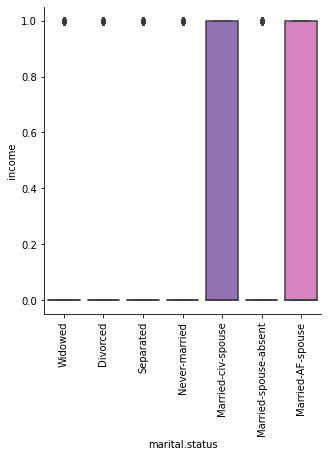

<Figure size 720x360 with 0 Axes>

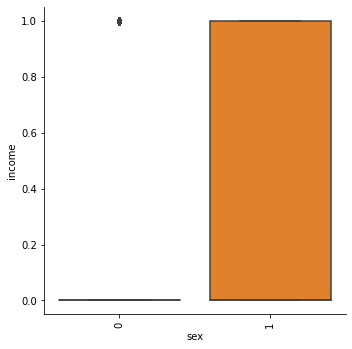

<Figure size 720x360 with 0 Axes>

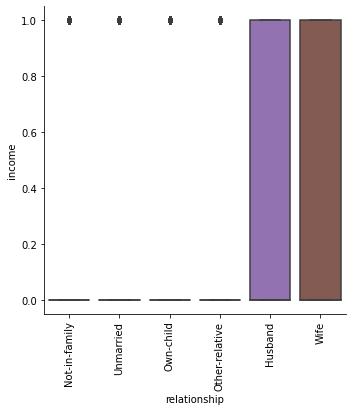

<Figure size 720x360 with 0 Axes>

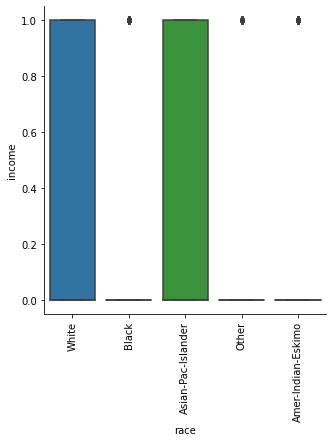

In [39]:
# Correlation of attributes with class label
plt.figure(figsize=(10,5))
sns.catplot(x="marital.status", y="income", kind="box", data=df)
plt.xticks(rotation=90)

plt.figure(figsize=(10,5))
sns.catplot(x="sex", y="income", kind="box", data=df)
plt.xticks(rotation=90)

plt.figure(figsize=(10,5))
sns.catplot(x="relationship", y="income", kind="box", data=df)
plt.xticks(rotation=90)

plt.figure(figsize=(10,5))
sns.catplot(x="race", y="income", kind="box", data=df)
plt.xticks(rotation=90)

In [40]:
# Data pre-processing
df = pd.concat([df, pd.get_dummies(df['race'], prefix='race')],axis=1)
df = pd.concat([df, pd.get_dummies(df['marital.status'], prefix='marital')],axis=1)
df = pd.concat([df, pd.get_dummies(df['workclass'], prefix='workclass')],axis=1)
df = pd.concat([df, pd.get_dummies(df['relationship'], prefix='relationship')],axis=1)
df = pd.concat([df, pd.get_dummies(df['education'], prefix='education')],axis=1)
df = pd.concat([df, pd.get_dummies(df['occupation'], prefix='occupation')],axis=1)

# age binning
df['ageUnder18'] = np.where(df['age'] < 18, 1, 0)
df['age18to24'] = np.where((df['age'] >= 18) & (df['age'] <= 24), 1, 0)
df['age25to44'] = np.where((df['age'] >= 25) & (df['age'] <= 44), 1, 0)
df['age45to64'] = np.where((df['age'] >= 45) & (df['age'] <= 64), 1, 0)
df['ageAbove65'] = np.where(df['age'] >= 65, 1, 0)

# privileged, unprivileged groups
privileged_groups = [{'sex': 1}] # Male
unprivileged_groups = [{'sex': 0}] # Female

df = df.drop(columns=['workclass', 'fnlwgt', 'education', 'education.num', 'occupation', \
                      'relationship', 'marital.status', 'race', 'native.country', 'capital.gain', \
                      'capital.loss', 'hours.per.week', 'age'])

In [41]:
df.describe()

# class imbalance: 75th percentile of income is 0.

,sex,income,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,marital_Divorced,marital_Married-AF-spouse,marital_Married-civ-spouse,...,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,ageUnder18,age18to24,age25to44,age45to64,ageAbove65
count,30162.000000,30162.000000,30162.000000,30162.000000,30162.000000,30162.000000,30162.00000,30162.000000,30162.000000,30162.000000,...,30162.000000,30162.000000,30162.000000,30162.000000,30162.000000,30162.000000,30162.000000,30162.000000,30162.000000,30162.000000
mean,0.675685,0.248922,0.009482,0.029673,0.093396,0.007659,0.85979,0.139712,0.000696,0.466315,...,0.133877,0.021351,0.118825,0.030237,0.052119,0.010875,0.150554,0.525429,0.280817,0.032325
std,0.468126,0.432396,0.096915,0.169687,0.290991,0.087179,0.34721,0.346694,0.026378,0.498872,...,0.340526,0.144555,0.323588,0.171241,0.222270,0.103715,0.357619,0.499361,0.449406,0.176866
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [42]:
def get_metrics(test_df, y_pred, unprivileged_groups, privileged_groups):
    test_bld = BinaryLabelDataset(df=test_df, label_names=['income'], protected_attribute_names=['sex'])
    pred_data = test_bld.copy()
    pred_data.labels = y_pred

    metric_selection = ClassificationMetric(
                    test_bld, pred_data,
                    unprivileged_groups=unprivileged_groups,
                    privileged_groups=privileged_groups)
    
    tnr_diff = metric_selection.true_negative_rate(1) - metric_selection.true_negative_rate(0)
    
    return [metric_selection.true_positive_rate_difference(), \
        metric_selection.statistical_parity_difference(),\
        tnr_diff,\
        metric_selection.accuracy()]

In [43]:
X = df.drop(columns='income')
y = df['income']

num_k = 5
metrics = [None] * num_k

# Regression on original data
k_fold = KFold(n_splits=num_k, random_state=None, shuffle=False)
for k, (train, test) in enumerate(k_fold.split(X, y)):
    test_df = X.iloc[test].copy()
    test_df['income'] = y.iloc[test]
    
    reg = LogisticRegression(max_iter=300)
    reg.fit(X.iloc[train], y.iloc[train])
    y_pred = reg.predict(X.iloc[test])
    metrics[k] = get_metrics(test_df, y_pred, unprivileged_groups, privileged_groups)

print("Results: Original")
mf_orig = pd.DataFrame(metrics, columns = ['TruePositiveRateDiff', 'StatisticalParityDiff', \
                                      'TrueNegativeRateDiff', 'Accuracy'])
mf_orig.mean()

Results: Original


TruePositiveRateDiff    -0.135077
StatisticalParityDiff   -0.181838
TrueNegativeRateDiff    -0.088531
Accuracy                 0.825942
dtype: float64

In [44]:
X = df.drop(columns='income')
y = df['income']

num_k = 5
metrics = [None] * num_k

k_fold = KFold(n_splits=num_k, random_state=None, shuffle=False)
for k, (train, test) in enumerate(k_fold.split(X, y)):
    test_df = df.iloc[test].copy()
    train_df = df.iloc[train].copy()
    
#     Remove all males
    train_df.drop(train_df[train_df.sex == 1].index, inplace=True) 

#     Remove married males
#     train_df.drop(train_df[(train_df.sex == 1) & (train_df['marital_Never-married'] !=1)]
#                   .index, inplace=True)
    
    reg = LogisticRegression(max_iter=300)
    reg.fit(train_df.drop(columns='income'), train_df['income'])
    y_pred = reg.predict(test_df.drop(columns='income'))
    metrics[k] = get_metrics(test_df, y_pred, unprivileged_groups, privileged_groups)

print("Results: Removed rows with predicate")
mf_predicate = pd.DataFrame(metrics, columns = ['TruePositiveRateDiff', 'StatisticalParityDiff', \
                                      'TrueNegativeRateDiff', 'Accuracy'])
mf_predicate.mean()

Results: Removed rows with predicate


TruePositiveRateDiff     0.107588
StatisticalParityDiff   -0.053610
TrueNegativeRateDiff    -0.018711
Accuracy                 0.802338
dtype: float64

In [ ]:
# Compute influence of each row by deleting it and retraining the model
train, test = train_test_split(df, test_size=0.3)
X_train = train.drop(columns='income')
y_train = train['income']

X_test = test.drop(columns='income')
y_test = test['income']

infs = pd.DataFrame(columns = ['TruePositiveRateDiff', 'StatisticalParityDiff', \
                                      'TrueNegativeRateDiff', 'Accuracy'])
reg = LogisticRegression(max_iter=200)
for i in range(0, len(X_train)):
    X_train_remove_one_row = X_train.drop(X_train.index[i])
    y_train_remove_one_row = y_train.drop(y_train.index[i])
    reg.fit(X_train_remove_one_row, y_train_remove_one_row)
    y_pred = reg.predict(X_test)
    metrics = get_metrics(test, y_pred, unprivileged_groups, privileged_groups)
    inf = mf_orig.mean() - metrics
    infs.loc[len(infs)] = inf
    print("influence of: "+ str(i)+ " out of " + str(len(X_train)))

infs = pd.DataFrame(infs)

influence of: 0 out of 21113
influence of: 1 out of 21113
influence of: 2 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 3 out of 21113
influence of: 4 out of 21113
influence of: 5 out of 21113
influence of: 6 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 7 out of 21113
influence of: 8 out of 21113
influence of: 9 out of 21113
influence of: 10 out of 21113
influence of: 11 out of 21113
influence of: 12 out of 21113
influence of: 13 out of 21113
influence of: 14 out of 21113
influence of: 15 out of 21113
influence of: 16 out of 21113
influence of: 17 out of 21113
influence of: 18 out of 21113
influence of: 19 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 20 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 21 out of 21113
influence of: 22 out of 21113
influence of: 23 out of 21113
influence of: 24 out of 21113
influence of: 25 out of 21113
influence of: 26 out of 21113
influence of: 27 out of 21113
influence of: 28 out of 21113
influence of: 29 out of 21113
influence of: 30 out of 21113
influence of: 31 out of 21113
influence of: 32 out of 21113
influence of: 33 out of 21113
influence of: 34 out of 21113
influence of: 35 out of 21113
influence of: 36 out of 21113
influence of: 37 out of 21113
influence of: 38 out of 21113
influence of: 39 out of 21113
influence of: 40 out of 21113
influence of: 41 out of 21113
influence of: 42 out of 21113
influence of: 43 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 44 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 45 out of 21113
influence of: 46 out of 21113
influence of: 47 out of 21113
influence of: 48 out of 21113
influence of: 49 out of 21113
influence of: 50 out of 21113
influence of: 51 out of 21113
influence of: 52 out of 21113
influence of: 53 out of 21113
influence of: 54 out of 21113
influence of: 55 out of 21113
influence of: 56 out of 21113
influence of: 57 out of 21113
influence of: 58 out of 21113
influence of: 59 out of 21113
influence of: 60 out of 21113
influence of: 61 out of 21113
influence of: 62 out of 21113
influence of: 63 out of 21113
influence of: 64 out of 21113
influence of: 65 out of 21113
influence of: 66 out of 21113
influence of: 67 out of 21113
influence of: 68 out of 21113
influence of: 69 out of 21113
influence of: 70 out of 21113
influence of: 71 out of 21113
influence of: 72 out of 21113
influence of: 73 out of 21113
influence of: 74 out of 21113
influence of: 75 out of 21113
influence of: 76 out of 21113
influence of: 77 out of 21113
influence 

/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 96 out of 21113
influence of: 97 out of 21113
influence of: 98 out of 21113
influence of: 99 out of 21113
influence of: 100 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 101 out of 21113
influence of: 102 out of 21113
influence of: 103 out of 21113
influence of: 104 out of 21113
influence of: 105 out of 21113
influence of: 106 out of 21113
influence of: 107 out of 21113
influence of: 108 out of 21113
influence of: 109 out of 21113
influence of: 110 out of 21113
influence of: 111 out of 21113
influence of: 112 out of 21113
influence of: 113 out of 21113
influence of: 114 out of 21113
influence of: 115 out of 21113
influence of: 116 out of 21113
influence of: 117 out of 21113
influence of: 118 out of 21113
influence of: 119 out of 21113
influence of: 120 out of 21113
influence of: 121 out of 21113
influence of: 122 out of 21113
influence of: 123 out of 21113
influence of: 124 out of 21113
influence of: 125 out of 21113
influence of: 126 out of 21113
influence of: 127 out of 21113
influence of: 128 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 129 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 130 out of 21113
influence of: 131 out of 21113
influence of: 132 out of 21113
influence of: 133 out of 21113
influence of: 134 out of 21113
influence of: 135 out of 21113
influence of: 136 out of 21113
influence of: 137 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 138 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 139 out of 21113
influence of: 140 out of 21113
influence of: 141 out of 21113
influence of: 142 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 143 out of 21113
influence of: 144 out of 21113
influence of: 145 out of 21113
influence of: 146 out of 21113
influence of: 147 out of 21113
influence of: 148 out of 21113
influence of: 149 out of 21113
influence of: 150 out of 21113
influence of: 151 out of 21113
influence of: 152 out of 21113
influence of: 153 out of 21113
influence of: 154 out of 21113
influence of: 155 out of 21113
influence of: 156 out of 21113
influence of: 157 out of 21113
influence of: 158 out of 21113
influence of: 159 out of 21113
influence of: 160 out of 21113
influence of: 161 out of 21113
influence of: 162 out of 21113
influence of: 163 out of 21113
influence of: 164 out of 21113
influence of: 165 out of 21113
influence of: 166 out of 21113
influence of: 167 out of 21113
influence of: 168 out of 21113
influence of: 169 out of 21113
influence of: 170 out of 21113
influence of: 171 out of 21113
influence of: 172 out of 21113
influence of: 173 out of 21113
influence of: 174 out of 21113
influenc

/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 179 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 180 out of 21113
influence of: 181 out of 21113
influence of: 182 out of 21113
influence of: 183 out of 21113
influence of: 184 out of 21113
influence of: 185 out of 21113
influence of: 186 out of 21113
influence of: 187 out of 21113
influence of: 188 out of 21113
influence of: 189 out of 21113
influence of: 190 out of 21113
influence of: 191 out of 21113
influence of: 192 out of 21113
influence of: 193 out of 21113
influence of: 194 out of 21113
influence of: 195 out of 21113
influence of: 196 out of 21113
influence of: 197 out of 21113
influence of: 198 out of 21113
influence of: 199 out of 21113
influence of: 200 out of 21113
influence of: 201 out of 21113
influence of: 202 out of 21113
influence of: 203 out of 21113
influence of: 204 out of 21113
influence of: 205 out of 21113
influence of: 206 out of 21113
influence of: 207 out of 21113
influence of: 208 out of 21113
influence of: 209 out of 21113
influence of: 210 out of 21113
influence of: 211 out of 21113
influenc

/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 243 out of 21113
influence of: 244 out of 21113
influence of: 245 out of 21113
influence of: 246 out of 21113
influence of: 247 out of 21113
influence of: 248 out of 21113
influence of: 249 out of 21113
influence of: 250 out of 21113
influence of: 251 out of 21113
influence of: 252 out of 21113
influence of: 253 out of 21113
influence of: 254 out of 21113
influence of: 255 out of 21113
influence of: 256 out of 21113
influence of: 257 out of 21113
influence of: 258 out of 21113
influence of: 259 out of 21113
influence of: 260 out of 21113
influence of: 261 out of 21113
influence of: 262 out of 21113
influence of: 263 out of 21113
influence of: 264 out of 21113
influence of: 265 out of 21113
influence of: 266 out of 21113
influence of: 267 out of 21113
influence of: 268 out of 21113
influence of: 269 out of 21113
influence of: 270 out of 21113
influence of: 271 out of 21113
influence of: 272 out of 21113
influence of: 273 out of 21113
influence of: 274 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 275 out of 21113
influence of: 276 out of 21113
influence of: 277 out of 21113
influence of: 278 out of 21113
influence of: 279 out of 21113
influence of: 280 out of 21113
influence of: 281 out of 21113
influence of: 282 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 283 out of 21113
influence of: 284 out of 21113
influence of: 285 out of 21113
influence of: 286 out of 21113
influence of: 287 out of 21113
influence of: 288 out of 21113
influence of: 289 out of 21113
influence of: 290 out of 21113
influence of: 291 out of 21113
influence of: 292 out of 21113
influence of: 293 out of 21113
influence of: 294 out of 21113
influence of: 295 out of 21113
influence of: 296 out of 21113
influence of: 297 out of 21113
influence of: 298 out of 21113
influence of: 299 out of 21113
influence of: 300 out of 21113
influence of: 301 out of 21113
influence of: 302 out of 21113
influence of: 303 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 304 out of 21113
influence of: 305 out of 21113
influence of: 306 out of 21113
influence of: 307 out of 21113
influence of: 308 out of 21113
influence of: 309 out of 21113
influence of: 310 out of 21113
influence of: 311 out of 21113
influence of: 312 out of 21113
influence of: 313 out of 21113
influence of: 314 out of 21113
influence of: 315 out of 21113
influence of: 316 out of 21113
influence of: 317 out of 21113
influence of: 318 out of 21113
influence of: 319 out of 21113
influence of: 320 out of 21113
influence of: 321 out of 21113
influence of: 322 out of 21113
influence of: 323 out of 21113
influence of: 324 out of 21113
influence of: 325 out of 21113
influence of: 326 out of 21113
influence of: 327 out of 21113
influence of: 328 out of 21113
influence of: 329 out of 21113
influence of: 330 out of 21113
influence of: 331 out of 21113
influence of: 332 out of 21113
influence of: 333 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 334 out of 21113
influence of: 335 out of 21113
influence of: 336 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 337 out of 21113
influence of: 338 out of 21113
influence of: 339 out of 21113
influence of: 340 out of 21113
influence of: 341 out of 21113
influence of: 342 out of 21113
influence of: 343 out of 21113
influence of: 344 out of 21113
influence of: 345 out of 21113
influence of: 346 out of 21113
influence of: 347 out of 21113
influence of: 348 out of 21113
influence of: 349 out of 21113
influence of: 350 out of 21113
influence of: 351 out of 21113
influence of: 352 out of 21113
influence of: 353 out of 21113
influence of: 354 out of 21113
influence of: 355 out of 21113
influence of: 356 out of 21113
influence of: 357 out of 21113
influence of: 358 out of 21113
influence of: 359 out of 21113
influence of: 360 out of 21113
influence of: 361 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 362 out of 21113
influence of: 363 out of 21113
influence of: 364 out of 21113
influence of: 365 out of 21113
influence of: 366 out of 21113
influence of: 367 out of 21113
influence of: 368 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 369 out of 21113
influence of: 370 out of 21113
influence of: 371 out of 21113
influence of: 372 out of 21113
influence of: 373 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 374 out of 21113
influence of: 375 out of 21113
influence of: 376 out of 21113
influence of: 377 out of 21113
influence of: 378 out of 21113
influence of: 379 out of 21113
influence of: 380 out of 21113
influence of: 381 out of 21113
influence of: 382 out of 21113
influence of: 383 out of 21113
influence of: 384 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 385 out of 21113
influence of: 386 out of 21113
influence of: 387 out of 21113
influence of: 388 out of 21113
influence of: 389 out of 21113
influence of: 390 out of 21113
influence of: 391 out of 21113
influence of: 392 out of 21113
influence of: 393 out of 21113
influence of: 394 out of 21113
influence of: 395 out of 21113
influence of: 396 out of 21113
influence of: 397 out of 21113
influence of: 398 out of 21113
influence of: 399 out of 21113
influence of: 400 out of 21113
influence of: 401 out of 21113
influence of: 402 out of 21113
influence of: 403 out of 21113
influence of: 404 out of 21113
influence of: 405 out of 21113
influence of: 406 out of 21113
influence of: 407 out of 21113
influence of: 408 out of 21113
influence of: 409 out of 21113
influence of: 410 out of 21113
influence of: 411 out of 21113
influence of: 412 out of 21113
influence of: 413 out of 21113
influence of: 414 out of 21113
influence of: 415 out of 21113
influence of: 416 out of 21113
influenc

/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 430 out of 21113
influence of: 431 out of 21113
influence of: 432 out of 21113
influence of: 433 out of 21113
influence of: 434 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 435 out of 21113
influence of: 436 out of 21113
influence of: 437 out of 21113
influence of: 438 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 439 out of 21113
influence of: 440 out of 21113
influence of: 441 out of 21113
influence of: 442 out of 21113
influence of: 443 out of 21113
influence of: 444 out of 21113
influence of: 445 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 446 out of 21113
influence of: 447 out of 21113
influence of: 448 out of 21113
influence of: 449 out of 21113
influence of: 450 out of 21113
influence of: 451 out of 21113
influence of: 452 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 453 out of 21113
influence of: 454 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 455 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 456 out of 21113
influence of: 457 out of 21113
influence of: 458 out of 21113
influence of: 459 out of 21113
influence of: 460 out of 21113
influence of: 461 out of 21113
influence of: 462 out of 21113
influence of: 463 out of 21113
influence of: 464 out of 21113
influence of: 465 out of 21113
influence of: 466 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 467 out of 21113
influence of: 468 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 469 out of 21113
influence of: 470 out of 21113
influence of: 471 out of 21113
influence of: 472 out of 21113
influence of: 473 out of 21113
influence of: 474 out of 21113
influence of: 475 out of 21113
influence of: 476 out of 21113
influence of: 477 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 478 out of 21113
influence of: 479 out of 21113
influence of: 480 out of 21113
influence of: 481 out of 21113
influence of: 482 out of 21113
influence of: 483 out of 21113
influence of: 484 out of 21113
influence of: 485 out of 21113
influence of: 486 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 487 out of 21113
influence of: 488 out of 21113
influence of: 489 out of 21113
influence of: 490 out of 21113
influence of: 491 out of 21113
influence of: 492 out of 21113
influence of: 493 out of 21113
influence of: 494 out of 21113
influence of: 495 out of 21113
influence of: 496 out of 21113
influence of: 497 out of 21113
influence of: 498 out of 21113
influence of: 499 out of 21113
influence of: 500 out of 21113
influence of: 501 out of 21113
influence of: 502 out of 21113
influence of: 503 out of 21113
influence of: 504 out of 21113
influence of: 505 out of 21113
influence of: 506 out of 21113
influence of: 507 out of 21113
influence of: 508 out of 21113
influence of: 509 out of 21113
influence of: 510 out of 21113
influence of: 511 out of 21113
influence of: 512 out of 21113
influence of: 513 out of 21113
influence of: 514 out of 21113
influence of: 515 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 516 out of 21113
influence of: 517 out of 21113
influence of: 518 out of 21113
influence of: 519 out of 21113
influence of: 520 out of 21113
influence of: 521 out of 21113
influence of: 522 out of 21113
influence of: 523 out of 21113
influence of: 524 out of 21113
influence of: 525 out of 21113
influence of: 526 out of 21113
influence of: 527 out of 21113
influence of: 528 out of 21113
influence of: 529 out of 21113
influence of: 530 out of 21113
influence of: 531 out of 21113
influence of: 532 out of 21113
influence of: 533 out of 21113
influence of: 534 out of 21113
influence of: 535 out of 21113
influence of: 536 out of 21113
influence of: 537 out of 21113
influence of: 538 out of 21113
influence of: 539 out of 21113
influence of: 540 out of 21113
influence of: 541 out of 21113
influence of: 542 out of 21113
influence of: 543 out of 21113
influence of: 544 out of 21113
influence of: 545 out of 21113
influence of: 546 out of 21113
influence of: 547 out of 21113
influenc

/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 549 out of 21113
influence of: 550 out of 21113
influence of: 551 out of 21113
influence of: 552 out of 21113
influence of: 553 out of 21113
influence of: 554 out of 21113
influence of: 555 out of 21113
influence of: 556 out of 21113
influence of: 557 out of 21113
influence of: 558 out of 21113
influence of: 559 out of 21113
influence of: 560 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 561 out of 21113
influence of: 562 out of 21113
influence of: 563 out of 21113
influence of: 564 out of 21113
influence of: 565 out of 21113
influence of: 566 out of 21113
influence of: 567 out of 21113
influence of: 568 out of 21113
influence of: 569 out of 21113
influence of: 570 out of 21113
influence of: 571 out of 21113
influence of: 572 out of 21113
influence of: 573 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 574 out of 21113
influence of: 575 out of 21113
influence of: 576 out of 21113
influence of: 577 out of 21113
influence of: 578 out of 21113
influence of: 579 out of 21113
influence of: 580 out of 21113
influence of: 581 out of 21113
influence of: 582 out of 21113
influence of: 583 out of 21113
influence of: 584 out of 21113
influence of: 585 out of 21113
influence of: 586 out of 21113
influence of: 587 out of 21113
influence of: 588 out of 21113
influence of: 589 out of 21113
influence of: 590 out of 21113
influence of: 591 out of 21113
influence of: 592 out of 21113
influence of: 593 out of 21113
influence of: 594 out of 21113
influence of: 595 out of 21113
influence of: 596 out of 21113
influence of: 597 out of 21113
influence of: 598 out of 21113
influence of: 599 out of 21113
influence of: 600 out of 21113
influence of: 601 out of 21113
influence of: 602 out of 21113
influence of: 603 out of 21113
influence of: 604 out of 21113
influence of: 605 out of 21113
influenc

/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 619 out of 21113
influence of: 620 out of 21113
influence of: 621 out of 21113
influence of: 622 out of 21113
influence of: 623 out of 21113
influence of: 624 out of 21113
influence of: 625 out of 21113
influence of: 626 out of 21113
influence of: 627 out of 21113
influence of: 628 out of 21113
influence of: 629 out of 21113
influence of: 630 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 631 out of 21113
influence of: 632 out of 21113
influence of: 633 out of 21113
influence of: 634 out of 21113
influence of: 635 out of 21113
influence of: 636 out of 21113
influence of: 637 out of 21113
influence of: 638 out of 21113
influence of: 639 out of 21113
influence of: 640 out of 21113
influence of: 641 out of 21113
influence of: 642 out of 21113
influence of: 643 out of 21113
influence of: 644 out of 21113
influence of: 645 out of 21113
influence of: 646 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 647 out of 21113
influence of: 648 out of 21113
influence of: 649 out of 21113
influence of: 650 out of 21113
influence of: 651 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 652 out of 21113
influence of: 653 out of 21113
influence of: 654 out of 21113
influence of: 655 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 656 out of 21113
influence of: 657 out of 21113
influence of: 658 out of 21113
influence of: 659 out of 21113
influence of: 660 out of 21113
influence of: 661 out of 21113
influence of: 662 out of 21113
influence of: 663 out of 21113
influence of: 664 out of 21113
influence of: 665 out of 21113
influence of: 666 out of 21113
influence of: 667 out of 21113
influence of: 668 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 669 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 670 out of 21113
influence of: 671 out of 21113
influence of: 672 out of 21113
influence of: 673 out of 21113
influence of: 674 out of 21113
influence of: 675 out of 21113
influence of: 676 out of 21113
influence of: 677 out of 21113
influence of: 678 out of 21113
influence of: 679 out of 21113
influence of: 680 out of 21113
influence of: 681 out of 21113
influence of: 682 out of 21113
influence of: 683 out of 21113
influence of: 684 out of 21113
influence of: 685 out of 21113
influence of: 686 out of 21113
influence of: 687 out of 21113
influence of: 688 out of 21113
influence of: 689 out of 21113
influence of: 690 out of 21113
influence of: 691 out of 21113
influence of: 692 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 693 out of 21113
influence of: 694 out of 21113
influence of: 695 out of 21113
influence of: 696 out of 21113
influence of: 697 out of 21113
influence of: 698 out of 21113
influence of: 699 out of 21113
influence of: 700 out of 21113
influence of: 701 out of 21113
influence of: 702 out of 21113
influence of: 703 out of 21113
influence of: 704 out of 21113
influence of: 705 out of 21113
influence of: 706 out of 21113
influence of: 707 out of 21113
influence of: 708 out of 21113
influence of: 709 out of 21113
influence of: 710 out of 21113
influence of: 711 out of 21113
influence of: 712 out of 21113
influence of: 713 out of 21113
influence of: 714 out of 21113
influence of: 715 out of 21113
influence of: 716 out of 21113
influence of: 717 out of 21113
influence of: 718 out of 21113
influence of: 719 out of 21113
influence of: 720 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 721 out of 21113
influence of: 722 out of 21113
influence of: 723 out of 21113
influence of: 724 out of 21113
influence of: 725 out of 21113
influence of: 726 out of 21113
influence of: 727 out of 21113
influence of: 728 out of 21113
influence of: 729 out of 21113
influence of: 730 out of 21113
influence of: 731 out of 21113
influence of: 732 out of 21113
influence of: 733 out of 21113
influence of: 734 out of 21113
influence of: 735 out of 21113
influence of: 736 out of 21113
influence of: 737 out of 21113
influence of: 738 out of 21113
influence of: 739 out of 21113
influence of: 740 out of 21113
influence of: 741 out of 21113
influence of: 742 out of 21113
influence of: 743 out of 21113
influence of: 744 out of 21113
influence of: 745 out of 21113
influence of: 746 out of 21113
influence of: 747 out of 21113
influence of: 748 out of 21113
influence of: 749 out of 21113
influence of: 750 out of 21113
influence of: 751 out of 21113
influence of: 752 out of 21113
influenc

/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 772 out of 21113
influence of: 773 out of 21113
influence of: 774 out of 21113
influence of: 775 out of 21113
influence of: 776 out of 21113
influence of: 777 out of 21113
influence of: 778 out of 21113
influence of: 779 out of 21113
influence of: 780 out of 21113
influence of: 781 out of 21113
influence of: 782 out of 21113
influence of: 783 out of 21113
influence of: 784 out of 21113
influence of: 785 out of 21113
influence of: 786 out of 21113
influence of: 787 out of 21113
influence of: 788 out of 21113
influence of: 789 out of 21113
influence of: 790 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 791 out of 21113
influence of: 792 out of 21113
influence of: 793 out of 21113
influence of: 794 out of 21113
influence of: 795 out of 21113
influence of: 796 out of 21113
influence of: 797 out of 21113
influence of: 798 out of 21113
influence of: 799 out of 21113
influence of: 800 out of 21113
influence of: 801 out of 21113
influence of: 802 out of 21113
influence of: 803 out of 21113
influence of: 804 out of 21113
influence of: 805 out of 21113
influence of: 806 out of 21113
influence of: 807 out of 21113
influence of: 808 out of 21113
influence of: 809 out of 21113
influence of: 810 out of 21113
influence of: 811 out of 21113
influence of: 812 out of 21113
influence of: 813 out of 21113
influence of: 814 out of 21113
influence of: 815 out of 21113
influence of: 816 out of 21113
influence of: 817 out of 21113
influence of: 818 out of 21113
influence of: 819 out of 21113
influence of: 820 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 821 out of 21113
influence of: 822 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 823 out of 21113
influence of: 824 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 825 out of 21113
influence of: 826 out of 21113
influence of: 827 out of 21113
influence of: 828 out of 21113
influence of: 829 out of 21113
influence of: 830 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 831 out of 21113
influence of: 832 out of 21113
influence of: 833 out of 21113
influence of: 834 out of 21113
influence of: 835 out of 21113
influence of: 836 out of 21113
influence of: 837 out of 21113
influence of: 838 out of 21113
influence of: 839 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 840 out of 21113
influence of: 841 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 842 out of 21113
influence of: 843 out of 21113
influence of: 844 out of 21113
influence of: 845 out of 21113
influence of: 846 out of 21113
influence of: 847 out of 21113
influence of: 848 out of 21113
influence of: 849 out of 21113
influence of: 850 out of 21113
influence of: 851 out of 21113
influence of: 852 out of 21113
influence of: 853 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 854 out of 21113
influence of: 855 out of 21113
influence of: 856 out of 21113
influence of: 857 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 858 out of 21113
influence of: 859 out of 21113
influence of: 860 out of 21113
influence of: 861 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 862 out of 21113
influence of: 863 out of 21113
influence of: 864 out of 21113
influence of: 865 out of 21113
influence of: 866 out of 21113
influence of: 867 out of 21113
influence of: 868 out of 21113
influence of: 869 out of 21113
influence of: 870 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 871 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 872 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 873 out of 21113
influence of: 874 out of 21113
influence of: 875 out of 21113
influence of: 876 out of 21113
influence of: 877 out of 21113
influence of: 878 out of 21113
influence of: 879 out of 21113
influence of: 880 out of 21113
influence of: 881 out of 21113
influence of: 882 out of 21113
influence of: 883 out of 21113
influence of: 884 out of 21113
influence of: 885 out of 21113
influence of: 886 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 887 out of 21113
influence of: 888 out of 21113
influence of: 889 out of 21113
influence of: 890 out of 21113
influence of: 891 out of 21113
influence of: 892 out of 21113
influence of: 893 out of 21113
influence of: 894 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 895 out of 21113
influence of: 896 out of 21113
influence of: 897 out of 21113
influence of: 898 out of 21113
influence of: 899 out of 21113
influence of: 900 out of 21113
influence of: 901 out of 21113
influence of: 902 out of 21113
influence of: 903 out of 21113
influence of: 904 out of 21113
influence of: 905 out of 21113
influence of: 906 out of 21113
influence of: 907 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 908 out of 21113
influence of: 909 out of 21113
influence of: 910 out of 21113
influence of: 911 out of 21113
influence of: 912 out of 21113
influence of: 913 out of 21113
influence of: 914 out of 21113
influence of: 915 out of 21113
influence of: 916 out of 21113
influence of: 917 out of 21113
influence of: 918 out of 21113
influence of: 919 out of 21113
influence of: 920 out of 21113
influence of: 921 out of 21113
influence of: 922 out of 21113
influence of: 923 out of 21113
influence of: 924 out of 21113
influence of: 925 out of 21113
influence of: 926 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 927 out of 21113
influence of: 928 out of 21113
influence of: 929 out of 21113
influence of: 930 out of 21113
influence of: 931 out of 21113
influence of: 932 out of 21113
influence of: 933 out of 21113
influence of: 934 out of 21113
influence of: 935 out of 21113
influence of: 936 out of 21113
influence of: 937 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 938 out of 21113
influence of: 939 out of 21113
influence of: 940 out of 21113
influence of: 941 out of 21113
influence of: 942 out of 21113
influence of: 943 out of 21113
influence of: 944 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 945 out of 21113
influence of: 946 out of 21113
influence of: 947 out of 21113
influence of: 948 out of 21113
influence of: 949 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 950 out of 21113
influence of: 951 out of 21113
influence of: 952 out of 21113
influence of: 953 out of 21113
influence of: 954 out of 21113
influence of: 955 out of 21113
influence of: 956 out of 21113
influence of: 957 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 958 out of 21113
influence of: 959 out of 21113
influence of: 960 out of 21113
influence of: 961 out of 21113
influence of: 962 out of 21113
influence of: 963 out of 21113
influence of: 964 out of 21113
influence of: 965 out of 21113
influence of: 966 out of 21113
influence of: 967 out of 21113
influence of: 968 out of 21113
influence of: 969 out of 21113
influence of: 970 out of 21113
influence of: 971 out of 21113
influence of: 972 out of 21113
influence of: 973 out of 21113
influence of: 974 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 975 out of 21113
influence of: 976 out of 21113
influence of: 977 out of 21113
influence of: 978 out of 21113
influence of: 979 out of 21113
influence of: 980 out of 21113
influence of: 981 out of 21113
influence of: 982 out of 21113
influence of: 983 out of 21113
influence of: 984 out of 21113
influence of: 985 out of 21113
influence of: 986 out of 21113
influence of: 987 out of 21113
influence of: 988 out of 21113
influence of: 989 out of 21113
influence of: 990 out of 21113
influence of: 991 out of 21113
influence of: 992 out of 21113
influence of: 993 out of 21113
influence of: 994 out of 21113
influence of: 995 out of 21113
influence of: 996 out of 21113
influence of: 997 out of 21113
influence of: 998 out of 21113
influence of: 999 out of 21113
influence of: 1000 out of 21113
influence of: 1001 out of 21113
influence of: 1002 out of 21113
influence of: 1003 out of 21113
influence of: 1004 out of 21113
influence of: 1005 out of 21113
influence of: 1006 out of 21113
i

/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 1012 out of 21113
influence of: 1013 out of 21113
influence of: 1014 out of 21113
influence of: 1015 out of 21113
influence of: 1016 out of 21113
influence of: 1017 out of 21113
influence of: 1018 out of 21113
influence of: 1019 out of 21113
influence of: 1020 out of 21113
influence of: 1021 out of 21113
influence of: 1022 out of 21113
influence of: 1023 out of 21113
influence of: 1024 out of 21113
influence of: 1025 out of 21113
influence of: 1026 out of 21113
influence of: 1027 out of 21113
influence of: 1028 out of 21113
influence of: 1029 out of 21113
influence of: 1030 out of 21113
influence of: 1031 out of 21113
influence of: 1032 out of 21113
influence of: 1033 out of 21113
influence of: 1034 out of 21113
influence of: 1035 out of 21113
influence of: 1036 out of 21113
influence of: 1037 out of 21113
influence of: 1038 out of 21113
influence of: 1039 out of 21113
influence of: 1040 out of 21113
influence of: 1041 out of 21113
influence of: 1042 out of 21113
influenc

/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 1072 out of 21113
influence of: 1073 out of 21113
influence of: 1074 out of 21113
influence of: 1075 out of 21113
influence of: 1076 out of 21113
influence of: 1077 out of 21113
influence of: 1078 out of 21113
influence of: 1079 out of 21113
influence of: 1080 out of 21113
influence of: 1081 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 1082 out of 21113
influence of: 1083 out of 21113
influence of: 1084 out of 21113
influence of: 1085 out of 21113
influence of: 1086 out of 21113
influence of: 1087 out of 21113
influence of: 1088 out of 21113
influence of: 1089 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 1090 out of 21113
influence of: 1091 out of 21113
influence of: 1092 out of 21113
influence of: 1093 out of 21113
influence of: 1094 out of 21113
influence of: 1095 out of 21113
influence of: 1096 out of 21113
influence of: 1097 out of 21113
influence of: 1098 out of 21113
influence of: 1099 out of 21113
influence of: 1100 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 1101 out of 21113
influence of: 1102 out of 21113
influence of: 1103 out of 21113
influence of: 1104 out of 21113
influence of: 1105 out of 21113
influence of: 1106 out of 21113
influence of: 1107 out of 21113
influence of: 1108 out of 21113
influence of: 1109 out of 21113
influence of: 1110 out of 21113
influence of: 1111 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 1112 out of 21113
influence of: 1113 out of 21113
influence of: 1114 out of 21113
influence of: 1115 out of 21113
influence of: 1116 out of 21113
influence of: 1117 out of 21113
influence of: 1118 out of 21113
influence of: 1119 out of 21113
influence of: 1120 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 1121 out of 21113
influence of: 1122 out of 21113
influence of: 1123 out of 21113
influence of: 1124 out of 21113
influence of: 1125 out of 21113
influence of: 1126 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 1127 out of 21113
influence of: 1128 out of 21113
influence of: 1129 out of 21113
influence of: 1130 out of 21113
influence of: 1131 out of 21113
influence of: 1132 out of 21113
influence of: 1133 out of 21113
influence of: 1134 out of 21113
influence of: 1135 out of 21113
influence of: 1136 out of 21113
influence of: 1137 out of 21113
influence of: 1138 out of 21113
influence of: 1139 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 1140 out of 21113
influence of: 1141 out of 21113
influence of: 1142 out of 21113
influence of: 1143 out of 21113
influence of: 1144 out of 21113
influence of: 1145 out of 21113
influence of: 1146 out of 21113
influence of: 1147 out of 21113
influence of: 1148 out of 21113
influence of: 1149 out of 21113
influence of: 1150 out of 21113
influence of: 1151 out of 21113
influence of: 1152 out of 21113
influence of: 1153 out of 21113
influence of: 1154 out of 21113
influence of: 1155 out of 21113
influence of: 1156 out of 21113
influence of: 1157 out of 21113
influence of: 1158 out of 21113
influence of: 1159 out of 21113
influence of: 1160 out of 21113
influence of: 1161 out of 21113
influence of: 1162 out of 21113
influence of: 1163 out of 21113
influence of: 1164 out of 21113
influence of: 1165 out of 21113
influence of: 1166 out of 21113
influence of: 1167 out of 21113
influence of: 1168 out of 21113
influence of: 1169 out of 21113
influence of: 1170 out of 21113
influenc

/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 1173 out of 21113
influence of: 1174 out of 21113
influence of: 1175 out of 21113
influence of: 1176 out of 21113
influence of: 1177 out of 21113
influence of: 1178 out of 21113
influence of: 1179 out of 21113
influence of: 1180 out of 21113
influence of: 1181 out of 21113
influence of: 1182 out of 21113
influence of: 1183 out of 21113
influence of: 1184 out of 21113
influence of: 1185 out of 21113
influence of: 1186 out of 21113
influence of: 1187 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 1188 out of 21113
influence of: 1189 out of 21113
influence of: 1190 out of 21113
influence of: 1191 out of 21113
influence of: 1192 out of 21113
influence of: 1193 out of 21113
influence of: 1194 out of 21113
influence of: 1195 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 1196 out of 21113
influence of: 1197 out of 21113
influence of: 1198 out of 21113
influence of: 1199 out of 21113
influence of: 1200 out of 21113
influence of: 1201 out of 21113
influence of: 1202 out of 21113
influence of: 1203 out of 21113
influence of: 1204 out of 21113
influence of: 1205 out of 21113
influence of: 1206 out of 21113
influence of: 1207 out of 21113
influence of: 1208 out of 21113
influence of: 1209 out of 21113
influence of: 1210 out of 21113
influence of: 1211 out of 21113
influence of: 1212 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 1213 out of 21113
influence of: 1214 out of 21113
influence of: 1215 out of 21113
influence of: 1216 out of 21113
influence of: 1217 out of 21113
influence of: 1218 out of 21113
influence of: 1219 out of 21113
influence of: 1220 out of 21113
influence of: 1221 out of 21113
influence of: 1222 out of 21113
influence of: 1223 out of 21113
influence of: 1224 out of 21113
influence of: 1225 out of 21113
influence of: 1226 out of 21113
influence of: 1227 out of 21113
influence of: 1228 out of 21113
influence of: 1229 out of 21113
influence of: 1230 out of 21113
influence of: 1231 out of 21113
influence of: 1232 out of 21113
influence of: 1233 out of 21113
influence of: 1234 out of 21113
influence of: 1235 out of 21113
influence of: 1236 out of 21113
influence of: 1237 out of 21113
influence of: 1238 out of 21113
influence of: 1239 out of 21113
influence of: 1240 out of 21113
influence of: 1241 out of 21113
influence of: 1242 out of 21113
influence of: 1243 out of 21113
influenc

/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 1246 out of 21113
influence of: 1247 out of 21113
influence of: 1248 out of 21113
influence of: 1249 out of 21113
influence of: 1250 out of 21113
influence of: 1251 out of 21113
influence of: 1252 out of 21113
influence of: 1253 out of 21113
influence of: 1254 out of 21113
influence of: 1255 out of 21113
influence of: 1256 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 1257 out of 21113
influence of: 1258 out of 21113
influence of: 1259 out of 21113
influence of: 1260 out of 21113
influence of: 1261 out of 21113
influence of: 1262 out of 21113
influence of: 1263 out of 21113
influence of: 1264 out of 21113
influence of: 1265 out of 21113
influence of: 1266 out of 21113
influence of: 1267 out of 21113
influence of: 1268 out of 21113
influence of: 1269 out of 21113
influence of: 1270 out of 21113
influence of: 1271 out of 21113
influence of: 1272 out of 21113
influence of: 1273 out of 21113
influence of: 1274 out of 21113
influence of: 1275 out of 21113
influence of: 1276 out of 21113
influence of: 1277 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 1278 out of 21113
influence of: 1279 out of 21113
influence of: 1280 out of 21113
influence of: 1281 out of 21113
influence of: 1282 out of 21113
influence of: 1283 out of 21113
influence of: 1284 out of 21113
influence of: 1285 out of 21113
influence of: 1286 out of 21113
influence of: 1287 out of 21113
influence of: 1288 out of 21113
influence of: 1289 out of 21113
influence of: 1290 out of 21113
influence of: 1291 out of 21113
influence of: 1292 out of 21113
influence of: 1293 out of 21113
influence of: 1294 out of 21113
influence of: 1295 out of 21113
influence of: 1296 out of 21113
influence of: 1297 out of 21113
influence of: 1298 out of 21113
influence of: 1299 out of 21113
influence of: 1300 out of 21113
influence of: 1301 out of 21113
influence of: 1302 out of 21113
influence of: 1303 out of 21113
influence of: 1304 out of 21113
influence of: 1305 out of 21113
influence of: 1306 out of 21113
influence of: 1307 out of 21113
influence of: 1308 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 1309 out of 21113
influence of: 1310 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 1311 out of 21113
influence of: 1312 out of 21113
influence of: 1313 out of 21113
influence of: 1314 out of 21113
influence of: 1315 out of 21113
influence of: 1316 out of 21113
influence of: 1317 out of 21113
influence of: 1318 out of 21113
influence of: 1319 out of 21113
influence of: 1320 out of 21113
influence of: 1321 out of 21113
influence of: 1322 out of 21113
influence of: 1323 out of 21113
influence of: 1324 out of 21113
influence of: 1325 out of 21113
influence of: 1326 out of 21113
influence of: 1327 out of 21113
influence of: 1328 out of 21113
influence of: 1329 out of 21113
influence of: 1330 out of 21113
influence of: 1331 out of 21113
influence of: 1332 out of 21113
influence of: 1333 out of 21113
influence of: 1334 out of 21113
influence of: 1335 out of 21113
influence of: 1336 out of 21113
influence of: 1337 out of 21113
influence of: 1338 out of 21113
influence of: 1339 out of 21113
influence of: 1340 out of 21113
influence of: 1341 out of 21113
influenc

/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 1344 out of 21113
influence of: 1345 out of 21113
influence of: 1346 out of 21113
influence of: 1347 out of 21113
influence of: 1348 out of 21113
influence of: 1349 out of 21113
influence of: 1350 out of 21113
influence of: 1351 out of 21113
influence of: 1352 out of 21113
influence of: 1353 out of 21113
influence of: 1354 out of 21113
influence of: 1355 out of 21113
influence of: 1356 out of 21113
influence of: 1357 out of 21113
influence of: 1358 out of 21113
influence of: 1359 out of 21113
influence of: 1360 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 1361 out of 21113
influence of: 1362 out of 21113
influence of: 1363 out of 21113
influence of: 1364 out of 21113
influence of: 1365 out of 21113
influence of: 1366 out of 21113
influence of: 1367 out of 21113
influence of: 1368 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 1369 out of 21113
influence of: 1370 out of 21113
influence of: 1371 out of 21113
influence of: 1372 out of 21113
influence of: 1373 out of 21113
influence of: 1374 out of 21113
influence of: 1375 out of 21113
influence of: 1376 out of 21113
influence of: 1377 out of 21113
influence of: 1378 out of 21113
influence of: 1379 out of 21113
influence of: 1380 out of 21113
influence of: 1381 out of 21113
influence of: 1382 out of 21113
influence of: 1383 out of 21113
influence of: 1384 out of 21113
influence of: 1385 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 1386 out of 21113
influence of: 1387 out of 21113
influence of: 1388 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 1389 out of 21113
influence of: 1390 out of 21113
influence of: 1391 out of 21113
influence of: 1392 out of 21113
influence of: 1393 out of 21113
influence of: 1394 out of 21113
influence of: 1395 out of 21113
influence of: 1396 out of 21113
influence of: 1397 out of 21113
influence of: 1398 out of 21113
influence of: 1399 out of 21113
influence of: 1400 out of 21113
influence of: 1401 out of 21113
influence of: 1402 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 1403 out of 21113
influence of: 1404 out of 21113
influence of: 1405 out of 21113
influence of: 1406 out of 21113
influence of: 1407 out of 21113
influence of: 1408 out of 21113
influence of: 1409 out of 21113
influence of: 1410 out of 21113
influence of: 1411 out of 21113
influence of: 1412 out of 21113
influence of: 1413 out of 21113
influence of: 1414 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 1415 out of 21113
influence of: 1416 out of 21113
influence of: 1417 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 1418 out of 21113
influence of: 1419 out of 21113
influence of: 1420 out of 21113
influence of: 1421 out of 21113
influence of: 1422 out of 21113
influence of: 1423 out of 21113
influence of: 1424 out of 21113
influence of: 1425 out of 21113
influence of: 1426 out of 21113
influence of: 1427 out of 21113
influence of: 1428 out of 21113
influence of: 1429 out of 21113
influence of: 1430 out of 21113
influence of: 1431 out of 21113
influence of: 1432 out of 21113
influence of: 1433 out of 21113
influence of: 1434 out of 21113
influence of: 1435 out of 21113
influence of: 1436 out of 21113
influence of: 1437 out of 21113
influence of: 1438 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 1439 out of 21113
influence of: 1440 out of 21113
influence of: 1441 out of 21113
influence of: 1442 out of 21113
influence of: 1443 out of 21113
influence of: 1444 out of 21113
influence of: 1445 out of 21113
influence of: 1446 out of 21113
influence of: 1447 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 1448 out of 21113
influence of: 1449 out of 21113
influence of: 1450 out of 21113
influence of: 1451 out of 21113
influence of: 1452 out of 21113
influence of: 1453 out of 21113
influence of: 1454 out of 21113
influence of: 1455 out of 21113
influence of: 1456 out of 21113
influence of: 1457 out of 21113
influence of: 1458 out of 21113
influence of: 1459 out of 21113
influence of: 1460 out of 21113
influence of: 1461 out of 21113
influence of: 1462 out of 21113
influence of: 1463 out of 21113
influence of: 1464 out of 21113
influence of: 1465 out of 21113
influence of: 1466 out of 21113
influence of: 1467 out of 21113
influence of: 1468 out of 21113
influence of: 1469 out of 21113
influence of: 1470 out of 21113
influence of: 1471 out of 21113
influence of: 1472 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 1473 out of 21113
influence of: 1474 out of 21113
influence of: 1475 out of 21113
influence of: 1476 out of 21113
influence of: 1477 out of 21113
influence of: 1478 out of 21113
influence of: 1479 out of 21113
influence of: 1480 out of 21113
influence of: 1481 out of 21113
influence of: 1482 out of 21113
influence of: 1483 out of 21113
influence of: 1484 out of 21113
influence of: 1485 out of 21113
influence of: 1486 out of 21113
influence of: 1487 out of 21113
influence of: 1488 out of 21113
influence of: 1489 out of 21113
influence of: 1490 out of 21113
influence of: 1491 out of 21113
influence of: 1492 out of 21113
influence of: 1493 out of 21113
influence of: 1494 out of 21113
influence of: 1495 out of 21113
influence of: 1496 out of 21113
influence of: 1497 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 1498 out of 21113
influence of: 1499 out of 21113
influence of: 1500 out of 21113
influence of: 1501 out of 21113
influence of: 1502 out of 21113
influence of: 1503 out of 21113
influence of: 1504 out of 21113
influence of: 1505 out of 21113
influence of: 1506 out of 21113
influence of: 1507 out of 21113
influence of: 1508 out of 21113
influence of: 1509 out of 21113
influence of: 1510 out of 21113
influence of: 1511 out of 21113
influence of: 1512 out of 21113
influence of: 1513 out of 21113
influence of: 1514 out of 21113
influence of: 1515 out of 21113
influence of: 1516 out of 21113
influence of: 1517 out of 21113
influence of: 1518 out of 21113
influence of: 1519 out of 21113
influence of: 1520 out of 21113
influence of: 1521 out of 21113
influence of: 1522 out of 21113
influence of: 1523 out of 21113
influence of: 1524 out of 21113
influence of: 1525 out of 21113
influence of: 1526 out of 21113
influence of: 1527 out of 21113
influence of: 1528 out of 21113
influenc

/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 1557 out of 21113
influence of: 1558 out of 21113
influence of: 1559 out of 21113
influence of: 1560 out of 21113
influence of: 1561 out of 21113
influence of: 1562 out of 21113
influence of: 1563 out of 21113
influence of: 1564 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 1565 out of 21113
influence of: 1566 out of 21113
influence of: 1567 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 1568 out of 21113
influence of: 1569 out of 21113
influence of: 1570 out of 21113
influence of: 1571 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 1572 out of 21113
influence of: 1573 out of 21113
influence of: 1574 out of 21113
influence of: 1575 out of 21113
influence of: 1576 out of 21113
influence of: 1577 out of 21113
influence of: 1578 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 1579 out of 21113
influence of: 1580 out of 21113
influence of: 1581 out of 21113
influence of: 1582 out of 21113
influence of: 1583 out of 21113
influence of: 1584 out of 21113
influence of: 1585 out of 21113
influence of: 1586 out of 21113
influence of: 1587 out of 21113
influence of: 1588 out of 21113
influence of: 1589 out of 21113
influence of: 1590 out of 21113
influence of: 1591 out of 21113
influence of: 1592 out of 21113
influence of: 1593 out of 21113
influence of: 1594 out of 21113
influence of: 1595 out of 21113
influence of: 1596 out of 21113
influence of: 1597 out of 21113
influence of: 1598 out of 21113
influence of: 1599 out of 21113
influence of: 1600 out of 21113
influence of: 1601 out of 21113
influence of: 1602 out of 21113
influence of: 1603 out of 21113
influence of: 1604 out of 21113
influence of: 1605 out of 21113
influence of: 1606 out of 21113
influence of: 1607 out of 21113
influence of: 1608 out of 21113
influence of: 1609 out of 21113
influenc

/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 1629 out of 21113
influence of: 1630 out of 21113
influence of: 1631 out of 21113
influence of: 1632 out of 21113
influence of: 1633 out of 21113
influence of: 1634 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 1635 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 1636 out of 21113
influence of: 1637 out of 21113
influence of: 1638 out of 21113
influence of: 1639 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 1640 out of 21113
influence of: 1641 out of 21113
influence of: 1642 out of 21113
influence of: 1643 out of 21113
influence of: 1644 out of 21113
influence of: 1645 out of 21113
influence of: 1646 out of 21113
influence of: 1647 out of 21113
influence of: 1648 out of 21113
influence of: 1649 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 1650 out of 21113
influence of: 1651 out of 21113
influence of: 1652 out of 21113
influence of: 1653 out of 21113
influence of: 1654 out of 21113
influence of: 1655 out of 21113
influence of: 1656 out of 21113
influence of: 1657 out of 21113
influence of: 1658 out of 21113
influence of: 1659 out of 21113
influence of: 1660 out of 21113
influence of: 1661 out of 21113
influence of: 1662 out of 21113
influence of: 1663 out of 21113
influence of: 1664 out of 21113
influence of: 1665 out of 21113
influence of: 1666 out of 21113
influence of: 1667 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 1668 out of 21113
influence of: 1669 out of 21113
influence of: 1670 out of 21113
influence of: 1671 out of 21113
influence of: 1672 out of 21113
influence of: 1673 out of 21113
influence of: 1674 out of 21113
influence of: 1675 out of 21113
influence of: 1676 out of 21113
influence of: 1677 out of 21113
influence of: 1678 out of 21113
influence of: 1679 out of 21113
influence of: 1680 out of 21113
influence of: 1681 out of 21113
influence of: 1682 out of 21113
influence of: 1683 out of 21113
influence of: 1684 out of 21113
influence of: 1685 out of 21113
influence of: 1686 out of 21113
influence of: 1687 out of 21113
influence of: 1688 out of 21113
influence of: 1689 out of 21113
influence of: 1690 out of 21113
influence of: 1691 out of 21113
influence of: 1692 out of 21113
influence of: 1693 out of 21113
influence of: 1694 out of 21113
influence of: 1695 out of 21113
influence of: 1696 out of 21113
influence of: 1697 out of 21113
influence of: 1698 out of 21113
influenc

/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 1712 out of 21113
influence of: 1713 out of 21113
influence of: 1714 out of 21113
influence of: 1715 out of 21113
influence of: 1716 out of 21113
influence of: 1717 out of 21113
influence of: 1718 out of 21113
influence of: 1719 out of 21113
influence of: 1720 out of 21113
influence of: 1721 out of 21113
influence of: 1722 out of 21113
influence of: 1723 out of 21113
influence of: 1724 out of 21113
influence of: 1725 out of 21113
influence of: 1726 out of 21113
influence of: 1727 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 1728 out of 21113
influence of: 1729 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 1730 out of 21113
influence of: 1731 out of 21113
influence of: 1732 out of 21113
influence of: 1733 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 1734 out of 21113
influence of: 1735 out of 21113
influence of: 1736 out of 21113
influence of: 1737 out of 21113
influence of: 1738 out of 21113
influence of: 1739 out of 21113
influence of: 1740 out of 21113
influence of: 1741 out of 21113
influence of: 1742 out of 21113
influence of: 1743 out of 21113
influence of: 1744 out of 21113
influence of: 1745 out of 21113
influence of: 1746 out of 21113
influence of: 1747 out of 21113
influence of: 1748 out of 21113
influence of: 1749 out of 21113
influence of: 1750 out of 21113
influence of: 1751 out of 21113
influence of: 1752 out of 21113
influence of: 1753 out of 21113
influence of: 1754 out of 21113
influence of: 1755 out of 21113
influence of: 1756 out of 21113
influence of: 1757 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 1758 out of 21113
influence of: 1759 out of 21113
influence of: 1760 out of 21113
influence of: 1761 out of 21113
influence of: 1762 out of 21113
influence of: 1763 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 1764 out of 21113
influence of: 1765 out of 21113
influence of: 1766 out of 21113
influence of: 1767 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 1768 out of 21113
influence of: 1769 out of 21113
influence of: 1770 out of 21113
influence of: 1771 out of 21113
influence of: 1772 out of 21113
influence of: 1773 out of 21113
influence of: 1774 out of 21113
influence of: 1775 out of 21113
influence of: 1776 out of 21113
influence of: 1777 out of 21113
influence of: 1778 out of 21113
influence of: 1779 out of 21113
influence of: 1780 out of 21113
influence of: 1781 out of 21113
influence of: 1782 out of 21113
influence of: 1783 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 1784 out of 21113
influence of: 1785 out of 21113
influence of: 1786 out of 21113
influence of: 1787 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 1788 out of 21113
influence of: 1789 out of 21113
influence of: 1790 out of 21113
influence of: 1791 out of 21113
influence of: 1792 out of 21113
influence of: 1793 out of 21113
influence of: 1794 out of 21113
influence of: 1795 out of 21113
influence of: 1796 out of 21113
influence of: 1797 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 1798 out of 21113
influence of: 1799 out of 21113
influence of: 1800 out of 21113
influence of: 1801 out of 21113
influence of: 1802 out of 21113
influence of: 1803 out of 21113
influence of: 1804 out of 21113
influence of: 1805 out of 21113
influence of: 1806 out of 21113
influence of: 1807 out of 21113
influence of: 1808 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 1809 out of 21113
influence of: 1810 out of 21113
influence of: 1811 out of 21113
influence of: 1812 out of 21113
influence of: 1813 out of 21113
influence of: 1814 out of 21113
influence of: 1815 out of 21113
influence of: 1816 out of 21113
influence of: 1817 out of 21113
influence of: 1818 out of 21113
influence of: 1819 out of 21113
influence of: 1820 out of 21113
influence of: 1821 out of 21113
influence of: 1822 out of 21113
influence of: 1823 out of 21113
influence of: 1824 out of 21113
influence of: 1825 out of 21113
influence of: 1826 out of 21113
influence of: 1827 out of 21113
influence of: 1828 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 1829 out of 21113
influence of: 1830 out of 21113
influence of: 1831 out of 21113
influence of: 1832 out of 21113
influence of: 1833 out of 21113
influence of: 1834 out of 21113
influence of: 1835 out of 21113
influence of: 1836 out of 21113
influence of: 1837 out of 21113
influence of: 1838 out of 21113
influence of: 1839 out of 21113
influence of: 1840 out of 21113
influence of: 1841 out of 21113
influence of: 1842 out of 21113
influence of: 1843 out of 21113
influence of: 1844 out of 21113
influence of: 1845 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 1846 out of 21113
influence of: 1847 out of 21113
influence of: 1848 out of 21113
influence of: 1849 out of 21113
influence of: 1850 out of 21113
influence of: 1851 out of 21113
influence of: 1852 out of 21113
influence of: 1853 out of 21113
influence of: 1854 out of 21113
influence of: 1855 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 1856 out of 21113
influence of: 1857 out of 21113
influence of: 1858 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 1859 out of 21113
influence of: 1860 out of 21113
influence of: 1861 out of 21113
influence of: 1862 out of 21113
influence of: 1863 out of 21113
influence of: 1864 out of 21113
influence of: 1865 out of 21113
influence of: 1866 out of 21113
influence of: 1867 out of 21113
influence of: 1868 out of 21113
influence of: 1869 out of 21113
influence of: 1870 out of 21113
influence of: 1871 out of 21113
influence of: 1872 out of 21113
influence of: 1873 out of 21113
influence of: 1874 out of 21113
influence of: 1875 out of 21113
influence of: 1876 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 1877 out of 21113
influence of: 1878 out of 21113
influence of: 1879 out of 21113
influence of: 1880 out of 21113
influence of: 1881 out of 21113
influence of: 1882 out of 21113
influence of: 1883 out of 21113
influence of: 1884 out of 21113
influence of: 1885 out of 21113
influence of: 1886 out of 21113
influence of: 1887 out of 21113
influence of: 1888 out of 21113
influence of: 1889 out of 21113
influence of: 1890 out of 21113
influence of: 1891 out of 21113
influence of: 1892 out of 21113
influence of: 1893 out of 21113
influence of: 1894 out of 21113
influence of: 1895 out of 21113
influence of: 1896 out of 21113
influence of: 1897 out of 21113
influence of: 1898 out of 21113
influence of: 1899 out of 21113
influence of: 1900 out of 21113
influence of: 1901 out of 21113
influence of: 1902 out of 21113
influence of: 1903 out of 21113
influence of: 1904 out of 21113
influence of: 1905 out of 21113
influence of: 1906 out of 21113
influence of: 1907 out of 21113
influenc

/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 1924 out of 21113
influence of: 1925 out of 21113
influence of: 1926 out of 21113
influence of: 1927 out of 21113
influence of: 1928 out of 21113
influence of: 1929 out of 21113
influence of: 1930 out of 21113
influence of: 1931 out of 21113
influence of: 1932 out of 21113
influence of: 1933 out of 21113
influence of: 1934 out of 21113
influence of: 1935 out of 21113
influence of: 1936 out of 21113
influence of: 1937 out of 21113
influence of: 1938 out of 21113
influence of: 1939 out of 21113
influence of: 1940 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 1941 out of 21113
influence of: 1942 out of 21113
influence of: 1943 out of 21113
influence of: 1944 out of 21113
influence of: 1945 out of 21113
influence of: 1946 out of 21113
influence of: 1947 out of 21113
influence of: 1948 out of 21113
influence of: 1949 out of 21113
influence of: 1950 out of 21113
influence of: 1951 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 1952 out of 21113
influence of: 1953 out of 21113
influence of: 1954 out of 21113
influence of: 1955 out of 21113
influence of: 1956 out of 21113
influence of: 1957 out of 21113
influence of: 1958 out of 21113
influence of: 1959 out of 21113
influence of: 1960 out of 21113
influence of: 1961 out of 21113
influence of: 1962 out of 21113
influence of: 1963 out of 21113
influence of: 1964 out of 21113
influence of: 1965 out of 21113
influence of: 1966 out of 21113
influence of: 1967 out of 21113
influence of: 1968 out of 21113
influence of: 1969 out of 21113
influence of: 1970 out of 21113
influence of: 1971 out of 21113
influence of: 1972 out of 21113
influence of: 1973 out of 21113
influence of: 1974 out of 21113
influence of: 1975 out of 21113
influence of: 1976 out of 21113
influence of: 1977 out of 21113
influence of: 1978 out of 21113
influence of: 1979 out of 21113
influence of: 1980 out of 21113
influence of: 1981 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 1982 out of 21113
influence of: 1983 out of 21113
influence of: 1984 out of 21113
influence of: 1985 out of 21113
influence of: 1986 out of 21113
influence of: 1987 out of 21113
influence of: 1988 out of 21113
influence of: 1989 out of 21113
influence of: 1990 out of 21113
influence of: 1991 out of 21113
influence of: 1992 out of 21113
influence of: 1993 out of 21113
influence of: 1994 out of 21113
influence of: 1995 out of 21113
influence of: 1996 out of 21113
influence of: 1997 out of 21113
influence of: 1998 out of 21113
influence of: 1999 out of 21113
influence of: 2000 out of 21113
influence of: 2001 out of 21113
influence of: 2002 out of 21113
influence of: 2003 out of 21113
influence of: 2004 out of 21113
influence of: 2005 out of 21113
influence of: 2006 out of 21113
influence of: 2007 out of 21113
influence of: 2008 out of 21113
influence of: 2009 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2010 out of 21113
influence of: 2011 out of 21113
influence of: 2012 out of 21113
influence of: 2013 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2014 out of 21113
influence of: 2015 out of 21113
influence of: 2016 out of 21113
influence of: 2017 out of 21113
influence of: 2018 out of 21113
influence of: 2019 out of 21113
influence of: 2020 out of 21113
influence of: 2021 out of 21113
influence of: 2022 out of 21113
influence of: 2023 out of 21113
influence of: 2024 out of 21113
influence of: 2025 out of 21113
influence of: 2026 out of 21113
influence of: 2027 out of 21113
influence of: 2028 out of 21113
influence of: 2029 out of 21113
influence of: 2030 out of 21113
influence of: 2031 out of 21113
influence of: 2032 out of 21113
influence of: 2033 out of 21113
influence of: 2034 out of 21113
influence of: 2035 out of 21113
influence of: 2036 out of 21113
influence of: 2037 out of 21113
influence of: 2038 out of 21113
influence of: 2039 out of 21113
influence of: 2040 out of 21113
influence of: 2041 out of 21113
influence of: 2042 out of 21113
influence of: 2043 out of 21113
influence of: 2044 out of 21113
influenc

/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2056 out of 21113
influence of: 2057 out of 21113
influence of: 2058 out of 21113
influence of: 2059 out of 21113
influence of: 2060 out of 21113
influence of: 2061 out of 21113
influence of: 2062 out of 21113
influence of: 2063 out of 21113
influence of: 2064 out of 21113
influence of: 2065 out of 21113
influence of: 2066 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2067 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2068 out of 21113
influence of: 2069 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2070 out of 21113
influence of: 2071 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2072 out of 21113
influence of: 2073 out of 21113
influence of: 2074 out of 21113
influence of: 2075 out of 21113
influence of: 2076 out of 21113
influence of: 2077 out of 21113
influence of: 2078 out of 21113
influence of: 2079 out of 21113
influence of: 2080 out of 21113
influence of: 2081 out of 21113
influence of: 2082 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2083 out of 21113
influence of: 2084 out of 21113
influence of: 2085 out of 21113
influence of: 2086 out of 21113
influence of: 2087 out of 21113
influence of: 2088 out of 21113
influence of: 2089 out of 21113
influence of: 2090 out of 21113
influence of: 2091 out of 21113
influence of: 2092 out of 21113
influence of: 2093 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2094 out of 21113
influence of: 2095 out of 21113
influence of: 2096 out of 21113
influence of: 2097 out of 21113
influence of: 2098 out of 21113
influence of: 2099 out of 21113
influence of: 2100 out of 21113
influence of: 2101 out of 21113
influence of: 2102 out of 21113
influence of: 2103 out of 21113
influence of: 2104 out of 21113
influence of: 2105 out of 21113
influence of: 2106 out of 21113
influence of: 2107 out of 21113
influence of: 2108 out of 21113
influence of: 2109 out of 21113
influence of: 2110 out of 21113
influence of: 2111 out of 21113
influence of: 2112 out of 21113
influence of: 2113 out of 21113
influence of: 2114 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2115 out of 21113
influence of: 2116 out of 21113
influence of: 2117 out of 21113
influence of: 2118 out of 21113
influence of: 2119 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2120 out of 21113
influence of: 2121 out of 21113
influence of: 2122 out of 21113
influence of: 2123 out of 21113
influence of: 2124 out of 21113
influence of: 2125 out of 21113
influence of: 2126 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2127 out of 21113
influence of: 2128 out of 21113
influence of: 2129 out of 21113
influence of: 2130 out of 21113
influence of: 2131 out of 21113
influence of: 2132 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2133 out of 21113
influence of: 2134 out of 21113
influence of: 2135 out of 21113
influence of: 2136 out of 21113
influence of: 2137 out of 21113
influence of: 2138 out of 21113
influence of: 2139 out of 21113
influence of: 2140 out of 21113
influence of: 2141 out of 21113
influence of: 2142 out of 21113
influence of: 2143 out of 21113
influence of: 2144 out of 21113
influence of: 2145 out of 21113
influence of: 2146 out of 21113
influence of: 2147 out of 21113
influence of: 2148 out of 21113
influence of: 2149 out of 21113
influence of: 2150 out of 21113
influence of: 2151 out of 21113
influence of: 2152 out of 21113
influence of: 2153 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2154 out of 21113
influence of: 2155 out of 21113
influence of: 2156 out of 21113
influence of: 2157 out of 21113
influence of: 2158 out of 21113
influence of: 2159 out of 21113
influence of: 2160 out of 21113
influence of: 2161 out of 21113
influence of: 2162 out of 21113
influence of: 2163 out of 21113
influence of: 2164 out of 21113
influence of: 2165 out of 21113
influence of: 2166 out of 21113
influence of: 2167 out of 21113
influence of: 2168 out of 21113
influence of: 2169 out of 21113
influence of: 2170 out of 21113
influence of: 2171 out of 21113
influence of: 2172 out of 21113
influence of: 2173 out of 21113
influence of: 2174 out of 21113
influence of: 2175 out of 21113
influence of: 2176 out of 21113
influence of: 2177 out of 21113
influence of: 2178 out of 21113
influence of: 2179 out of 21113
influence of: 2180 out of 21113
influence of: 2181 out of 21113
influence of: 2182 out of 21113
influence of: 2183 out of 21113
influence of: 2184 out of 21113
influenc

/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2197 out of 21113
influence of: 2198 out of 21113
influence of: 2199 out of 21113
influence of: 2200 out of 21113
influence of: 2201 out of 21113
influence of: 2202 out of 21113
influence of: 2203 out of 21113
influence of: 2204 out of 21113
influence of: 2205 out of 21113
influence of: 2206 out of 21113
influence of: 2207 out of 21113
influence of: 2208 out of 21113
influence of: 2209 out of 21113
influence of: 2210 out of 21113
influence of: 2211 out of 21113
influence of: 2212 out of 21113
influence of: 2213 out of 21113
influence of: 2214 out of 21113
influence of: 2215 out of 21113
influence of: 2216 out of 21113
influence of: 2217 out of 21113
influence of: 2218 out of 21113
influence of: 2219 out of 21113
influence of: 2220 out of 21113
influence of: 2221 out of 21113
influence of: 2222 out of 21113
influence of: 2223 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2224 out of 21113
influence of: 2225 out of 21113
influence of: 2226 out of 21113
influence of: 2227 out of 21113
influence of: 2228 out of 21113
influence of: 2229 out of 21113
influence of: 2230 out of 21113
influence of: 2231 out of 21113
influence of: 2232 out of 21113
influence of: 2233 out of 21113
influence of: 2234 out of 21113
influence of: 2235 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2236 out of 21113
influence of: 2237 out of 21113
influence of: 2238 out of 21113
influence of: 2239 out of 21113
influence of: 2240 out of 21113
influence of: 2241 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2242 out of 21113
influence of: 2243 out of 21113
influence of: 2244 out of 21113
influence of: 2245 out of 21113
influence of: 2246 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2247 out of 21113
influence of: 2248 out of 21113
influence of: 2249 out of 21113
influence of: 2250 out of 21113
influence of: 2251 out of 21113
influence of: 2252 out of 21113
influence of: 2253 out of 21113
influence of: 2254 out of 21113
influence of: 2255 out of 21113
influence of: 2256 out of 21113
influence of: 2257 out of 21113
influence of: 2258 out of 21113
influence of: 2259 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2260 out of 21113
influence of: 2261 out of 21113
influence of: 2262 out of 21113
influence of: 2263 out of 21113
influence of: 2264 out of 21113
influence of: 2265 out of 21113
influence of: 2266 out of 21113
influence of: 2267 out of 21113
influence of: 2268 out of 21113
influence of: 2269 out of 21113
influence of: 2270 out of 21113
influence of: 2271 out of 21113
influence of: 2272 out of 21113
influence of: 2273 out of 21113
influence of: 2274 out of 21113
influence of: 2275 out of 21113
influence of: 2276 out of 21113
influence of: 2277 out of 21113
influence of: 2278 out of 21113
influence of: 2279 out of 21113
influence of: 2280 out of 21113
influence of: 2281 out of 21113
influence of: 2282 out of 21113
influence of: 2283 out of 21113
influence of: 2284 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2285 out of 21113
influence of: 2286 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2287 out of 21113
influence of: 2288 out of 21113
influence of: 2289 out of 21113
influence of: 2290 out of 21113
influence of: 2291 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2292 out of 21113
influence of: 2293 out of 21113
influence of: 2294 out of 21113
influence of: 2295 out of 21113
influence of: 2296 out of 21113
influence of: 2297 out of 21113
influence of: 2298 out of 21113
influence of: 2299 out of 21113
influence of: 2300 out of 21113
influence of: 2301 out of 21113
influence of: 2302 out of 21113
influence of: 2303 out of 21113
influence of: 2304 out of 21113
influence of: 2305 out of 21113
influence of: 2306 out of 21113
influence of: 2307 out of 21113
influence of: 2308 out of 21113
influence of: 2309 out of 21113
influence of: 2310 out of 21113
influence of: 2311 out of 21113
influence of: 2312 out of 21113
influence of: 2313 out of 21113
influence of: 2314 out of 21113
influence of: 2315 out of 21113
influence of: 2316 out of 21113
influence of: 2317 out of 21113
influence of: 2318 out of 21113
influence of: 2319 out of 21113
influence of: 2320 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2321 out of 21113
influence of: 2322 out of 21113
influence of: 2323 out of 21113
influence of: 2324 out of 21113
influence of: 2325 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2326 out of 21113
influence of: 2327 out of 21113
influence of: 2328 out of 21113
influence of: 2329 out of 21113
influence of: 2330 out of 21113
influence of: 2331 out of 21113
influence of: 2332 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2333 out of 21113
influence of: 2334 out of 21113
influence of: 2335 out of 21113
influence of: 2336 out of 21113
influence of: 2337 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2338 out of 21113
influence of: 2339 out of 21113
influence of: 2340 out of 21113
influence of: 2341 out of 21113
influence of: 2342 out of 21113
influence of: 2343 out of 21113
influence of: 2344 out of 21113
influence of: 2345 out of 21113
influence of: 2346 out of 21113
influence of: 2347 out of 21113
influence of: 2348 out of 21113
influence of: 2349 out of 21113
influence of: 2350 out of 21113
influence of: 2351 out of 21113
influence of: 2352 out of 21113
influence of: 2353 out of 21113
influence of: 2354 out of 21113
influence of: 2355 out of 21113
influence of: 2356 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2357 out of 21113
influence of: 2358 out of 21113
influence of: 2359 out of 21113
influence of: 2360 out of 21113
influence of: 2361 out of 21113
influence of: 2362 out of 21113
influence of: 2363 out of 21113
influence of: 2364 out of 21113
influence of: 2365 out of 21113
influence of: 2366 out of 21113
influence of: 2367 out of 21113
influence of: 2368 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2369 out of 21113
influence of: 2370 out of 21113
influence of: 2371 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2372 out of 21113
influence of: 2373 out of 21113
influence of: 2374 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2375 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2376 out of 21113
influence of: 2377 out of 21113
influence of: 2378 out of 21113
influence of: 2379 out of 21113
influence of: 2380 out of 21113
influence of: 2381 out of 21113
influence of: 2382 out of 21113
influence of: 2383 out of 21113
influence of: 2384 out of 21113
influence of: 2385 out of 21113
influence of: 2386 out of 21113
influence of: 2387 out of 21113
influence of: 2388 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2389 out of 21113
influence of: 2390 out of 21113
influence of: 2391 out of 21113
influence of: 2392 out of 21113
influence of: 2393 out of 21113
influence of: 2394 out of 21113
influence of: 2395 out of 21113
influence of: 2396 out of 21113
influence of: 2397 out of 21113
influence of: 2398 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2399 out of 21113
influence of: 2400 out of 21113
influence of: 2401 out of 21113
influence of: 2402 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2403 out of 21113
influence of: 2404 out of 21113
influence of: 2405 out of 21113
influence of: 2406 out of 21113
influence of: 2407 out of 21113
influence of: 2408 out of 21113
influence of: 2409 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2410 out of 21113
influence of: 2411 out of 21113
influence of: 2412 out of 21113
influence of: 2413 out of 21113
influence of: 2414 out of 21113
influence of: 2415 out of 21113
influence of: 2416 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2417 out of 21113
influence of: 2418 out of 21113
influence of: 2419 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2420 out of 21113
influence of: 2421 out of 21113
influence of: 2422 out of 21113
influence of: 2423 out of 21113
influence of: 2424 out of 21113
influence of: 2425 out of 21113
influence of: 2426 out of 21113
influence of: 2427 out of 21113
influence of: 2428 out of 21113
influence of: 2429 out of 21113
influence of: 2430 out of 21113
influence of: 2431 out of 21113
influence of: 2432 out of 21113
influence of: 2433 out of 21113
influence of: 2434 out of 21113
influence of: 2435 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2436 out of 21113
influence of: 2437 out of 21113
influence of: 2438 out of 21113
influence of: 2439 out of 21113
influence of: 2440 out of 21113
influence of: 2441 out of 21113
influence of: 2442 out of 21113
influence of: 2443 out of 21113
influence of: 2444 out of 21113
influence of: 2445 out of 21113
influence of: 2446 out of 21113
influence of: 2447 out of 21113
influence of: 2448 out of 21113
influence of: 2449 out of 21113
influence of: 2450 out of 21113
influence of: 2451 out of 21113
influence of: 2452 out of 21113
influence of: 2453 out of 21113
influence of: 2454 out of 21113
influence of: 2455 out of 21113
influence of: 2456 out of 21113
influence of: 2457 out of 21113
influence of: 2458 out of 21113
influence of: 2459 out of 21113
influence of: 2460 out of 21113
influence of: 2461 out of 21113
influence of: 2462 out of 21113
influence of: 2463 out of 21113
influence of: 2464 out of 21113
influence of: 2465 out of 21113
influence of: 2466 out of 21113
influenc

/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2499 out of 21113
influence of: 2500 out of 21113
influence of: 2501 out of 21113
influence of: 2502 out of 21113
influence of: 2503 out of 21113
influence of: 2504 out of 21113
influence of: 2505 out of 21113
influence of: 2506 out of 21113
influence of: 2507 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2508 out of 21113
influence of: 2509 out of 21113
influence of: 2510 out of 21113
influence of: 2511 out of 21113
influence of: 2512 out of 21113
influence of: 2513 out of 21113
influence of: 2514 out of 21113
influence of: 2515 out of 21113
influence of: 2516 out of 21113
influence of: 2517 out of 21113
influence of: 2518 out of 21113
influence of: 2519 out of 21113
influence of: 2520 out of 21113
influence of: 2521 out of 21113
influence of: 2522 out of 21113
influence of: 2523 out of 21113
influence of: 2524 out of 21113
influence of: 2525 out of 21113
influence of: 2526 out of 21113
influence of: 2527 out of 21113
influence of: 2528 out of 21113
influence of: 2529 out of 21113
influence of: 2530 out of 21113
influence of: 2531 out of 21113
influence of: 2532 out of 21113
influence of: 2533 out of 21113
influence of: 2534 out of 21113
influence of: 2535 out of 21113
influence of: 2536 out of 21113
influence of: 2537 out of 21113
influence of: 2538 out of 21113
influenc

/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2548 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2549 out of 21113
influence of: 2550 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2551 out of 21113
influence of: 2552 out of 21113
influence of: 2553 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2554 out of 21113
influence of: 2555 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2556 out of 21113
influence of: 2557 out of 21113
influence of: 2558 out of 21113
influence of: 2559 out of 21113
influence of: 2560 out of 21113
influence of: 2561 out of 21113
influence of: 2562 out of 21113
influence of: 2563 out of 21113
influence of: 2564 out of 21113
influence of: 2565 out of 21113
influence of: 2566 out of 21113
influence of: 2567 out of 21113
influence of: 2568 out of 21113
influence of: 2569 out of 21113
influence of: 2570 out of 21113
influence of: 2571 out of 21113
influence of: 2572 out of 21113
influence of: 2573 out of 21113
influence of: 2574 out of 21113
influence of: 2575 out of 21113
influence of: 2576 out of 21113
influence of: 2577 out of 21113
influence of: 2578 out of 21113
influence of: 2579 out of 21113
influence of: 2580 out of 21113
influence of: 2581 out of 21113
influence of: 2582 out of 21113
influence of: 2583 out of 21113
influence of: 2584 out of 21113
influence of: 2585 out of 21113
influence of: 2586 out of 21113
influenc

/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2602 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2603 out of 21113
influence of: 2604 out of 21113
influence of: 2605 out of 21113
influence of: 2606 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2607 out of 21113
influence of: 2608 out of 21113
influence of: 2609 out of 21113
influence of: 2610 out of 21113
influence of: 2611 out of 21113
influence of: 2612 out of 21113
influence of: 2613 out of 21113
influence of: 2614 out of 21113
influence of: 2615 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2616 out of 21113
influence of: 2617 out of 21113
influence of: 2618 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2619 out of 21113
influence of: 2620 out of 21113
influence of: 2621 out of 21113
influence of: 2622 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2623 out of 21113
influence of: 2624 out of 21113
influence of: 2625 out of 21113
influence of: 2626 out of 21113
influence of: 2627 out of 21113
influence of: 2628 out of 21113
influence of: 2629 out of 21113
influence of: 2630 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2631 out of 21113
influence of: 2632 out of 21113
influence of: 2633 out of 21113
influence of: 2634 out of 21113
influence of: 2635 out of 21113
influence of: 2636 out of 21113
influence of: 2637 out of 21113
influence of: 2638 out of 21113
influence of: 2639 out of 21113
influence of: 2640 out of 21113
influence of: 2641 out of 21113
influence of: 2642 out of 21113
influence of: 2643 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2644 out of 21113
influence of: 2645 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2646 out of 21113
influence of: 2647 out of 21113
influence of: 2648 out of 21113
influence of: 2649 out of 21113
influence of: 2650 out of 21113
influence of: 2651 out of 21113
influence of: 2652 out of 21113
influence of: 2653 out of 21113
influence of: 2654 out of 21113
influence of: 2655 out of 21113
influence of: 2656 out of 21113
influence of: 2657 out of 21113
influence of: 2658 out of 21113
influence of: 2659 out of 21113
influence of: 2660 out of 21113
influence of: 2661 out of 21113
influence of: 2662 out of 21113
influence of: 2663 out of 21113
influence of: 2664 out of 21113
influence of: 2665 out of 21113
influence of: 2666 out of 21113
influence of: 2667 out of 21113
influence of: 2668 out of 21113
influence of: 2669 out of 21113
influence of: 2670 out of 21113
influence of: 2671 out of 21113
influence of: 2672 out of 21113
influence of: 2673 out of 21113
influence of: 2674 out of 21113
influence of: 2675 out of 21113
influence of: 2676 out of 21113
influenc

/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2695 out of 21113
influence of: 2696 out of 21113
influence of: 2697 out of 21113
influence of: 2698 out of 21113
influence of: 2699 out of 21113
influence of: 2700 out of 21113
influence of: 2701 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2702 out of 21113
influence of: 2703 out of 21113
influence of: 2704 out of 21113
influence of: 2705 out of 21113
influence of: 2706 out of 21113
influence of: 2707 out of 21113
influence of: 2708 out of 21113
influence of: 2709 out of 21113
influence of: 2710 out of 21113
influence of: 2711 out of 21113
influence of: 2712 out of 21113
influence of: 2713 out of 21113
influence of: 2714 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2715 out of 21113
influence of: 2716 out of 21113
influence of: 2717 out of 21113
influence of: 2718 out of 21113
influence of: 2719 out of 21113
influence of: 2720 out of 21113
influence of: 2721 out of 21113
influence of: 2722 out of 21113
influence of: 2723 out of 21113
influence of: 2724 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2725 out of 21113
influence of: 2726 out of 21113
influence of: 2727 out of 21113
influence of: 2728 out of 21113
influence of: 2729 out of 21113
influence of: 2730 out of 21113
influence of: 2731 out of 21113
influence of: 2732 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2733 out of 21113
influence of: 2734 out of 21113
influence of: 2735 out of 21113
influence of: 2736 out of 21113
influence of: 2737 out of 21113
influence of: 2738 out of 21113
influence of: 2739 out of 21113
influence of: 2740 out of 21113
influence of: 2741 out of 21113
influence of: 2742 out of 21113
influence of: 2743 out of 21113
influence of: 2744 out of 21113
influence of: 2745 out of 21113
influence of: 2746 out of 21113
influence of: 2747 out of 21113
influence of: 2748 out of 21113
influence of: 2749 out of 21113
influence of: 2750 out of 21113
influence of: 2751 out of 21113
influence of: 2752 out of 21113
influence of: 2753 out of 21113
influence of: 2754 out of 21113
influence of: 2755 out of 21113
influence of: 2756 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2757 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2758 out of 21113
influence of: 2759 out of 21113
influence of: 2760 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2761 out of 21113
influence of: 2762 out of 21113
influence of: 2763 out of 21113
influence of: 2764 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2765 out of 21113
influence of: 2766 out of 21113
influence of: 2767 out of 21113
influence of: 2768 out of 21113
influence of: 2769 out of 21113
influence of: 2770 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2771 out of 21113
influence of: 2772 out of 21113
influence of: 2773 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2774 out of 21113
influence of: 2775 out of 21113
influence of: 2776 out of 21113
influence of: 2777 out of 21113
influence of: 2778 out of 21113
influence of: 2779 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2780 out of 21113
influence of: 2781 out of 21113
influence of: 2782 out of 21113
influence of: 2783 out of 21113
influence of: 2784 out of 21113
influence of: 2785 out of 21113
influence of: 2786 out of 21113
influence of: 2787 out of 21113
influence of: 2788 out of 21113
influence of: 2789 out of 21113
influence of: 2790 out of 21113
influence of: 2791 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2792 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2793 out of 21113
influence of: 2794 out of 21113
influence of: 2795 out of 21113
influence of: 2796 out of 21113
influence of: 2797 out of 21113
influence of: 2798 out of 21113
influence of: 2799 out of 21113
influence of: 2800 out of 21113
influence of: 2801 out of 21113
influence of: 2802 out of 21113
influence of: 2803 out of 21113
influence of: 2804 out of 21113
influence of: 2805 out of 21113
influence of: 2806 out of 21113
influence of: 2807 out of 21113
influence of: 2808 out of 21113
influence of: 2809 out of 21113
influence of: 2810 out of 21113
influence of: 2811 out of 21113
influence of: 2812 out of 21113
influence of: 2813 out of 21113
influence of: 2814 out of 21113
influence of: 2815 out of 21113
influence of: 2816 out of 21113
influence of: 2817 out of 21113
influence of: 2818 out of 21113
influence of: 2819 out of 21113
influence of: 2820 out of 21113
influence of: 2821 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2822 out of 21113
influence of: 2823 out of 21113
influence of: 2824 out of 21113
influence of: 2825 out of 21113
influence of: 2826 out of 21113
influence of: 2827 out of 21113
influence of: 2828 out of 21113
influence of: 2829 out of 21113
influence of: 2830 out of 21113
influence of: 2831 out of 21113
influence of: 2832 out of 21113
influence of: 2833 out of 21113
influence of: 2834 out of 21113
influence of: 2835 out of 21113
influence of: 2836 out of 21113
influence of: 2837 out of 21113
influence of: 2838 out of 21113
influence of: 2839 out of 21113
influence of: 2840 out of 21113
influence of: 2841 out of 21113
influence of: 2842 out of 21113
influence of: 2843 out of 21113
influence of: 2844 out of 21113
influence of: 2845 out of 21113
influence of: 2846 out of 21113
influence of: 2847 out of 21113
influence of: 2848 out of 21113
influence of: 2849 out of 21113
influence of: 2850 out of 21113
influence of: 2851 out of 21113
influence of: 2852 out of 21113
influenc

/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2857 out of 21113
influence of: 2858 out of 21113
influence of: 2859 out of 21113
influence of: 2860 out of 21113
influence of: 2861 out of 21113
influence of: 2862 out of 21113
influence of: 2863 out of 21113
influence of: 2864 out of 21113
influence of: 2865 out of 21113
influence of: 2866 out of 21113
influence of: 2867 out of 21113
influence of: 2868 out of 21113
influence of: 2869 out of 21113
influence of: 2870 out of 21113
influence of: 2871 out of 21113
influence of: 2872 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2873 out of 21113
influence of: 2874 out of 21113
influence of: 2875 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2876 out of 21113
influence of: 2877 out of 21113
influence of: 2878 out of 21113
influence of: 2879 out of 21113
influence of: 2880 out of 21113
influence of: 2881 out of 21113
influence of: 2882 out of 21113
influence of: 2883 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2884 out of 21113
influence of: 2885 out of 21113
influence of: 2886 out of 21113
influence of: 2887 out of 21113
influence of: 2888 out of 21113
influence of: 2889 out of 21113
influence of: 2890 out of 21113
influence of: 2891 out of 21113
influence of: 2892 out of 21113
influence of: 2893 out of 21113
influence of: 2894 out of 21113
influence of: 2895 out of 21113
influence of: 2896 out of 21113
influence of: 2897 out of 21113
influence of: 2898 out of 21113
influence of: 2899 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2900 out of 21113
influence of: 2901 out of 21113
influence of: 2902 out of 21113
influence of: 2903 out of 21113
influence of: 2904 out of 21113
influence of: 2905 out of 21113
influence of: 2906 out of 21113
influence of: 2907 out of 21113
influence of: 2908 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2909 out of 21113
influence of: 2910 out of 21113
influence of: 2911 out of 21113
influence of: 2912 out of 21113
influence of: 2913 out of 21113
influence of: 2914 out of 21113
influence of: 2915 out of 21113
influence of: 2916 out of 21113
influence of: 2917 out of 21113
influence of: 2918 out of 21113
influence of: 2919 out of 21113
influence of: 2920 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2921 out of 21113
influence of: 2922 out of 21113
influence of: 2923 out of 21113
influence of: 2924 out of 21113
influence of: 2925 out of 21113
influence of: 2926 out of 21113
influence of: 2927 out of 21113
influence of: 2928 out of 21113
influence of: 2929 out of 21113
influence of: 2930 out of 21113
influence of: 2931 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2932 out of 21113
influence of: 2933 out of 21113
influence of: 2934 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2935 out of 21113
influence of: 2936 out of 21113
influence of: 2937 out of 21113
influence of: 2938 out of 21113
influence of: 2939 out of 21113
influence of: 2940 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2941 out of 21113
influence of: 2942 out of 21113
influence of: 2943 out of 21113
influence of: 2944 out of 21113
influence of: 2945 out of 21113
influence of: 2946 out of 21113
influence of: 2947 out of 21113
influence of: 2948 out of 21113
influence of: 2949 out of 21113
influence of: 2950 out of 21113
influence of: 2951 out of 21113
influence of: 2952 out of 21113
influence of: 2953 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2954 out of 21113
influence of: 2955 out of 21113
influence of: 2956 out of 21113
influence of: 2957 out of 21113
influence of: 2958 out of 21113
influence of: 2959 out of 21113
influence of: 2960 out of 21113
influence of: 2961 out of 21113
influence of: 2962 out of 21113
influence of: 2963 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2964 out of 21113
influence of: 2965 out of 21113
influence of: 2966 out of 21113
influence of: 2967 out of 21113
influence of: 2968 out of 21113
influence of: 2969 out of 21113
influence of: 2970 out of 21113
influence of: 2971 out of 21113
influence of: 2972 out of 21113
influence of: 2973 out of 21113
influence of: 2974 out of 21113
influence of: 2975 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2976 out of 21113
influence of: 2977 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2978 out of 21113
influence of: 2979 out of 21113
influence of: 2980 out of 21113
influence of: 2981 out of 21113
influence of: 2982 out of 21113
influence of: 2983 out of 21113
influence of: 2984 out of 21113
influence of: 2985 out of 21113
influence of: 2986 out of 21113
influence of: 2987 out of 21113
influence of: 2988 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2989 out of 21113
influence of: 2990 out of 21113
influence of: 2991 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 2992 out of 21113
influence of: 2993 out of 21113
influence of: 2994 out of 21113
influence of: 2995 out of 21113
influence of: 2996 out of 21113
influence of: 2997 out of 21113
influence of: 2998 out of 21113
influence of: 2999 out of 21113
influence of: 3000 out of 21113
influence of: 3001 out of 21113
influence of: 3002 out of 21113
influence of: 3003 out of 21113
influence of: 3004 out of 21113
influence of: 3005 out of 21113
influence of: 3006 out of 21113
influence of: 3007 out of 21113
influence of: 3008 out of 21113
influence of: 3009 out of 21113
influence of: 3010 out of 21113
influence of: 3011 out of 21113
influence of: 3012 out of 21113
influence of: 3013 out of 21113
influence of: 3014 out of 21113
influence of: 3015 out of 21113
influence of: 3016 out of 21113
influence of: 3017 out of 21113
influence of: 3018 out of 21113
influence of: 3019 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 3020 out of 21113
influence of: 3021 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 3022 out of 21113
influence of: 3023 out of 21113
influence of: 3024 out of 21113
influence of: 3025 out of 21113
influence of: 3026 out of 21113
influence of: 3027 out of 21113
influence of: 3028 out of 21113
influence of: 3029 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 3030 out of 21113
influence of: 3031 out of 21113
influence of: 3032 out of 21113
influence of: 3033 out of 21113
influence of: 3034 out of 21113
influence of: 3035 out of 21113
influence of: 3036 out of 21113
influence of: 3037 out of 21113
influence of: 3038 out of 21113
influence of: 3039 out of 21113
influence of: 3040 out of 21113
influence of: 3041 out of 21113
influence of: 3042 out of 21113
influence of: 3043 out of 21113
influence of: 3044 out of 21113
influence of: 3045 out of 21113
influence of: 3046 out of 21113
influence of: 3047 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 3048 out of 21113
influence of: 3049 out of 21113
influence of: 3050 out of 21113
influence of: 3051 out of 21113
influence of: 3052 out of 21113
influence of: 3053 out of 21113
influence of: 3054 out of 21113
influence of: 3055 out of 21113
influence of: 3056 out of 21113
influence of: 3057 out of 21113
influence of: 3058 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 3059 out of 21113
influence of: 3060 out of 21113
influence of: 3061 out of 21113
influence of: 3062 out of 21113
influence of: 3063 out of 21113
influence of: 3064 out of 21113
influence of: 3065 out of 21113
influence of: 3066 out of 21113
influence of: 3067 out of 21113
influence of: 3068 out of 21113
influence of: 3069 out of 21113
influence of: 3070 out of 21113
influence of: 3071 out of 21113
influence of: 3072 out of 21113
influence of: 3073 out of 21113
influence of: 3074 out of 21113
influence of: 3075 out of 21113
influence of: 3076 out of 21113
influence of: 3077 out of 21113
influence of: 3078 out of 21113
influence of: 3079 out of 21113
influence of: 3080 out of 21113
influence of: 3081 out of 21113
influence of: 3082 out of 21113
influence of: 3083 out of 21113
influence of: 3084 out of 21113
influence of: 3085 out of 21113
influence of: 3086 out of 21113
influence of: 3087 out of 21113
influence of: 3088 out of 21113
influence of: 3089 out of 21113
influenc

/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 3128 out of 21113
influence of: 3129 out of 21113
influence of: 3130 out of 21113
influence of: 3131 out of 21113
influence of: 3132 out of 21113
influence of: 3133 out of 21113
influence of: 3134 out of 21113
influence of: 3135 out of 21113
influence of: 3136 out of 21113
influence of: 3137 out of 21113
influence of: 3138 out of 21113
influence of: 3139 out of 21113
influence of: 3140 out of 21113
influence of: 3141 out of 21113
influence of: 3142 out of 21113
influence of: 3143 out of 21113
influence of: 3144 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 3145 out of 21113
influence of: 3146 out of 21113
influence of: 3147 out of 21113
influence of: 3148 out of 21113
influence of: 3149 out of 21113
influence of: 3150 out of 21113
influence of: 3151 out of 21113
influence of: 3152 out of 21113
influence of: 3153 out of 21113
influence of: 3154 out of 21113
influence of: 3155 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 3156 out of 21113
influence of: 3157 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 3158 out of 21113
influence of: 3159 out of 21113
influence of: 3160 out of 21113
influence of: 3161 out of 21113
influence of: 3162 out of 21113
influence of: 3163 out of 21113
influence of: 3164 out of 21113
influence of: 3165 out of 21113
influence of: 3166 out of 21113
influence of: 3167 out of 21113
influence of: 3168 out of 21113
influence of: 3169 out of 21113
influence of: 3170 out of 21113
influence of: 3171 out of 21113
influence of: 3172 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 3173 out of 21113
influence of: 3174 out of 21113
influence of: 3175 out of 21113
influence of: 3176 out of 21113
influence of: 3177 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 3178 out of 21113
influence of: 3179 out of 21113
influence of: 3180 out of 21113
influence of: 3181 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 3182 out of 21113
influence of: 3183 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 3184 out of 21113
influence of: 3185 out of 21113
influence of: 3186 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 3187 out of 21113
influence of: 3188 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 3189 out of 21113
influence of: 3190 out of 21113
influence of: 3191 out of 21113
influence of: 3192 out of 21113
influence of: 3193 out of 21113
influence of: 3194 out of 21113
influence of: 3195 out of 21113
influence of: 3196 out of 21113
influence of: 3197 out of 21113
influence of: 3198 out of 21113
influence of: 3199 out of 21113
influence of: 3200 out of 21113
influence of: 3201 out of 21113
influence of: 3202 out of 21113
influence of: 3203 out of 21113
influence of: 3204 out of 21113
influence of: 3205 out of 21113
influence of: 3206 out of 21113
influence of: 3207 out of 21113
influence of: 3208 out of 21113
influence of: 3209 out of 21113
influence of: 3210 out of 21113
influence of: 3211 out of 21113
influence of: 3212 out of 21113
influence of: 3213 out of 21113
influence of: 3214 out of 21113
influence of: 3215 out of 21113
influence of: 3216 out of 21113
influence of: 3217 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 3218 out of 21113
influence of: 3219 out of 21113
influence of: 3220 out of 21113
influence of: 3221 out of 21113
influence of: 3222 out of 21113
influence of: 3223 out of 21113
influence of: 3224 out of 21113
influence of: 3225 out of 21113
influence of: 3226 out of 21113
influence of: 3227 out of 21113
influence of: 3228 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 3229 out of 21113
influence of: 3230 out of 21113
influence of: 3231 out of 21113
influence of: 3232 out of 21113
influence of: 3233 out of 21113
influence of: 3234 out of 21113
influence of: 3235 out of 21113
influence of: 3236 out of 21113
influence of: 3237 out of 21113
influence of: 3238 out of 21113
influence of: 3239 out of 21113
influence of: 3240 out of 21113
influence of: 3241 out of 21113
influence of: 3242 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 3243 out of 21113
influence of: 3244 out of 21113
influence of: 3245 out of 21113
influence of: 3246 out of 21113
influence of: 3247 out of 21113
influence of: 3248 out of 21113
influence of: 3249 out of 21113
influence of: 3250 out of 21113
influence of: 3251 out of 21113
influence of: 3252 out of 21113
influence of: 3253 out of 21113
influence of: 3254 out of 21113
influence of: 3255 out of 21113
influence of: 3256 out of 21113
influence of: 3257 out of 21113
influence of: 3258 out of 21113
influence of: 3259 out of 21113
influence of: 3260 out of 21113
influence of: 3261 out of 21113
influence of: 3262 out of 21113
influence of: 3263 out of 21113
influence of: 3264 out of 21113
influence of: 3265 out of 21113
influence of: 3266 out of 21113
influence of: 3267 out of 21113
influence of: 3268 out of 21113
influence of: 3269 out of 21113
influence of: 3270 out of 21113
influence of: 3271 out of 21113
influence of: 3272 out of 21113
influence of: 3273 out of 21113
influenc

/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 3286 out of 21113
influence of: 3287 out of 21113
influence of: 3288 out of 21113
influence of: 3289 out of 21113
influence of: 3290 out of 21113
influence of: 3291 out of 21113
influence of: 3292 out of 21113
influence of: 3293 out of 21113
influence of: 3294 out of 21113
influence of: 3295 out of 21113
influence of: 3296 out of 21113
influence of: 3297 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 3298 out of 21113
influence of: 3299 out of 21113
influence of: 3300 out of 21113
influence of: 3301 out of 21113
influence of: 3302 out of 21113
influence of: 3303 out of 21113
influence of: 3304 out of 21113
influence of: 3305 out of 21113
influence of: 3306 out of 21113
influence of: 3307 out of 21113
influence of: 3308 out of 21113
influence of: 3309 out of 21113
influence of: 3310 out of 21113
influence of: 3311 out of 21113
influence of: 3312 out of 21113
influence of: 3313 out of 21113
influence of: 3314 out of 21113
influence of: 3315 out of 21113
influence of: 3316 out of 21113
influence of: 3317 out of 21113
influence of: 3318 out of 21113
influence of: 3319 out of 21113
influence of: 3320 out of 21113
influence of: 3321 out of 21113
influence of: 3322 out of 21113
influence of: 3323 out of 21113
influence of: 3324 out of 21113
influence of: 3325 out of 21113
influence of: 3326 out of 21113
influence of: 3327 out of 21113
influence of: 3328 out of 21113
influenc

/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 3336 out of 21113
influence of: 3337 out of 21113
influence of: 3338 out of 21113
influence of: 3339 out of 21113
influence of: 3340 out of 21113
influence of: 3341 out of 21113
influence of: 3342 out of 21113
influence of: 3343 out of 21113
influence of: 3344 out of 21113
influence of: 3345 out of 21113
influence of: 3346 out of 21113
influence of: 3347 out of 21113
influence of: 3348 out of 21113
influence of: 3349 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 3350 out of 21113
influence of: 3351 out of 21113
influence of: 3352 out of 21113
influence of: 3353 out of 21113
influence of: 3354 out of 21113
influence of: 3355 out of 21113
influence of: 3356 out of 21113
influence of: 3357 out of 21113
influence of: 3358 out of 21113
influence of: 3359 out of 21113
influence of: 3360 out of 21113
influence of: 3361 out of 21113
influence of: 3362 out of 21113
influence of: 3363 out of 21113
influence of: 3364 out of 21113
influence of: 3365 out of 21113
influence of: 3366 out of 21113
influence of: 3367 out of 21113
influence of: 3368 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 3369 out of 21113
influence of: 3370 out of 21113
influence of: 3371 out of 21113
influence of: 3372 out of 21113
influence of: 3373 out of 21113
influence of: 3374 out of 21113
influence of: 3375 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 3376 out of 21113
influence of: 3377 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 3378 out of 21113
influence of: 3379 out of 21113
influence of: 3380 out of 21113
influence of: 3381 out of 21113
influence of: 3382 out of 21113
influence of: 3383 out of 21113
influence of: 3384 out of 21113
influence of: 3385 out of 21113
influence of: 3386 out of 21113
influence of: 3387 out of 21113
influence of: 3388 out of 21113
influence of: 3389 out of 21113
influence of: 3390 out of 21113
influence of: 3391 out of 21113
influence of: 3392 out of 21113
influence of: 3393 out of 21113
influence of: 3394 out of 21113
influence of: 3395 out of 21113
influence of: 3396 out of 21113
influence of: 3397 out of 21113
influence of: 3398 out of 21113
influence of: 3399 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 3400 out of 21113
influence of: 3401 out of 21113
influence of: 3402 out of 21113
influence of: 3403 out of 21113
influence of: 3404 out of 21113
influence of: 3405 out of 21113
influence of: 3406 out of 21113
influence of: 3407 out of 21113
influence of: 3408 out of 21113
influence of: 3409 out of 21113
influence of: 3410 out of 21113
influence of: 3411 out of 21113
influence of: 3412 out of 21113
influence of: 3413 out of 21113
influence of: 3414 out of 21113
influence of: 3415 out of 21113
influence of: 3416 out of 21113
influence of: 3417 out of 21113
influence of: 3418 out of 21113
influence of: 3419 out of 21113
influence of: 3420 out of 21113
influence of: 3421 out of 21113
influence of: 3422 out of 21113
influence of: 3423 out of 21113
influence of: 3424 out of 21113
influence of: 3425 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 3426 out of 21113
influence of: 3427 out of 21113
influence of: 3428 out of 21113
influence of: 3429 out of 21113
influence of: 3430 out of 21113
influence of: 3431 out of 21113
influence of: 3432 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 3433 out of 21113
influence of: 3434 out of 21113
influence of: 3435 out of 21113
influence of: 3436 out of 21113
influence of: 3437 out of 21113
influence of: 3438 out of 21113
influence of: 3439 out of 21113
influence of: 3440 out of 21113
influence of: 3441 out of 21113
influence of: 3442 out of 21113
influence of: 3443 out of 21113
influence of: 3444 out of 21113
influence of: 3445 out of 21113
influence of: 3446 out of 21113
influence of: 3447 out of 21113
influence of: 3448 out of 21113
influence of: 3449 out of 21113
influence of: 3450 out of 21113
influence of: 3451 out of 21113
influence of: 3452 out of 21113
influence of: 3453 out of 21113
influence of: 3454 out of 21113
influence of: 3455 out of 21113
influence of: 3456 out of 21113
influence of: 3457 out of 21113
influence of: 3458 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 3459 out of 21113
influence of: 3460 out of 21113
influence of: 3461 out of 21113
influence of: 3462 out of 21113
influence of: 3463 out of 21113
influence of: 3464 out of 21113
influence of: 3465 out of 21113
influence of: 3466 out of 21113
influence of: 3467 out of 21113
influence of: 3468 out of 21113
influence of: 3469 out of 21113
influence of: 3470 out of 21113
influence of: 3471 out of 21113
influence of: 3472 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 3473 out of 21113
influence of: 3474 out of 21113
influence of: 3475 out of 21113
influence of: 3476 out of 21113
influence of: 3477 out of 21113
influence of: 3478 out of 21113
influence of: 3479 out of 21113
influence of: 3480 out of 21113
influence of: 3481 out of 21113
influence of: 3482 out of 21113
influence of: 3483 out of 21113
influence of: 3484 out of 21113
influence of: 3485 out of 21113
influence of: 3486 out of 21113
influence of: 3487 out of 21113
influence of: 3488 out of 21113
influence of: 3489 out of 21113
influence of: 3490 out of 21113
influence of: 3491 out of 21113
influence of: 3492 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 3493 out of 21113
influence of: 3494 out of 21113
influence of: 3495 out of 21113
influence of: 3496 out of 21113
influence of: 3497 out of 21113
influence of: 3498 out of 21113
influence of: 3499 out of 21113
influence of: 3500 out of 21113
influence of: 3501 out of 21113
influence of: 3502 out of 21113
influence of: 3503 out of 21113
influence of: 3504 out of 21113
influence of: 3505 out of 21113
influence of: 3506 out of 21113
influence of: 3507 out of 21113
influence of: 3508 out of 21113
influence of: 3509 out of 21113
influence of: 3510 out of 21113
influence of: 3511 out of 21113
influence of: 3512 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 3513 out of 21113
influence of: 3514 out of 21113
influence of: 3515 out of 21113
influence of: 3516 out of 21113
influence of: 3517 out of 21113
influence of: 3518 out of 21113
influence of: 3519 out of 21113
influence of: 3520 out of 21113
influence of: 3521 out of 21113
influence of: 3522 out of 21113
influence of: 3523 out of 21113
influence of: 3524 out of 21113
influence of: 3525 out of 21113
influence of: 3526 out of 21113
influence of: 3527 out of 21113
influence of: 3528 out of 21113
influence of: 3529 out of 21113
influence of: 3530 out of 21113
influence of: 3531 out of 21113
influence of: 3532 out of 21113
influence of: 3533 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 3534 out of 21113
influence of: 3535 out of 21113
influence of: 3536 out of 21113
influence of: 3537 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 3538 out of 21113
influence of: 3539 out of 21113
influence of: 3540 out of 21113
influence of: 3541 out of 21113
influence of: 3542 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 3543 out of 21113
influence of: 3544 out of 21113
influence of: 3545 out of 21113
influence of: 3546 out of 21113
influence of: 3547 out of 21113
influence of: 3548 out of 21113
influence of: 3549 out of 21113
influence of: 3550 out of 21113
influence of: 3551 out of 21113
influence of: 3552 out of 21113
influence of: 3553 out of 21113
influence of: 3554 out of 21113
influence of: 3555 out of 21113
influence of: 3556 out of 21113
influence of: 3557 out of 21113
influence of: 3558 out of 21113
influence of: 3559 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 3560 out of 21113
influence of: 3561 out of 21113
influence of: 3562 out of 21113
influence of: 3563 out of 21113
influence of: 3564 out of 21113
influence of: 3565 out of 21113
influence of: 3566 out of 21113
influence of: 3567 out of 21113
influence of: 3568 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 3569 out of 21113
influence of: 3570 out of 21113
influence of: 3571 out of 21113
influence of: 3572 out of 21113
influence of: 3573 out of 21113
influence of: 3574 out of 21113
influence of: 3575 out of 21113
influence of: 3576 out of 21113
influence of: 3577 out of 21113
influence of: 3578 out of 21113
influence of: 3579 out of 21113
influence of: 3580 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 3581 out of 21113
influence of: 3582 out of 21113
influence of: 3583 out of 21113
influence of: 3584 out of 21113
influence of: 3585 out of 21113
influence of: 3586 out of 21113
influence of: 3587 out of 21113
influence of: 3588 out of 21113
influence of: 3589 out of 21113
influence of: 3590 out of 21113
influence of: 3591 out of 21113
influence of: 3592 out of 21113
influence of: 3593 out of 21113
influence of: 3594 out of 21113
influence of: 3595 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 3596 out of 21113
influence of: 3597 out of 21113
influence of: 3598 out of 21113
influence of: 3599 out of 21113
influence of: 3600 out of 21113
influence of: 3601 out of 21113
influence of: 3602 out of 21113
influence of: 3603 out of 21113
influence of: 3604 out of 21113
influence of: 3605 out of 21113
influence of: 3606 out of 21113
influence of: 3607 out of 21113
influence of: 3608 out of 21113
influence of: 3609 out of 21113
influence of: 3610 out of 21113
influence of: 3611 out of 21113
influence of: 3612 out of 21113
influence of: 3613 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 3614 out of 21113
influence of: 3615 out of 21113
influence of: 3616 out of 21113
influence of: 3617 out of 21113
influence of: 3618 out of 21113
influence of: 3619 out of 21113
influence of: 3620 out of 21113
influence of: 3621 out of 21113
influence of: 3622 out of 21113
influence of: 3623 out of 21113
influence of: 3624 out of 21113
influence of: 3625 out of 21113
influence of: 3626 out of 21113
influence of: 3627 out of 21113
influence of: 3628 out of 21113
influence of: 3629 out of 21113
influence of: 3630 out of 21113
influence of: 3631 out of 21113
influence of: 3632 out of 21113
influence of: 3633 out of 21113
influence of: 3634 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 3635 out of 21113
influence of: 3636 out of 21113
influence of: 3637 out of 21113
influence of: 3638 out of 21113
influence of: 3639 out of 21113
influence of: 3640 out of 21113
influence of: 3641 out of 21113
influence of: 3642 out of 21113
influence of: 3643 out of 21113
influence of: 3644 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 3645 out of 21113
influence of: 3646 out of 21113
influence of: 3647 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 3648 out of 21113
influence of: 3649 out of 21113
influence of: 3650 out of 21113
influence of: 3651 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 3652 out of 21113
influence of: 3653 out of 21113
influence of: 3654 out of 21113
influence of: 3655 out of 21113
influence of: 3656 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 3657 out of 21113
influence of: 3658 out of 21113
influence of: 3659 out of 21113
influence of: 3660 out of 21113
influence of: 3661 out of 21113
influence of: 3662 out of 21113
influence of: 3663 out of 21113
influence of: 3664 out of 21113
influence of: 3665 out of 21113
influence of: 3666 out of 21113
influence of: 3667 out of 21113
influence of: 3668 out of 21113
influence of: 3669 out of 21113
influence of: 3670 out of 21113
influence of: 3671 out of 21113
influence of: 3672 out of 21113
influence of: 3673 out of 21113
influence of: 3674 out of 21113
influence of: 3675 out of 21113
influence of: 3676 out of 21113
influence of: 3677 out of 21113
influence of: 3678 out of 21113
influence of: 3679 out of 21113
influence of: 3680 out of 21113
influence of: 3681 out of 21113
influence of: 3682 out of 21113
influence of: 3683 out of 21113
influence of: 3684 out of 21113
influence of: 3685 out of 21113
influence of: 3686 out of 21113
influence of: 3687 out of 21113
influenc

/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 3690 out of 21113
influence of: 3691 out of 21113
influence of: 3692 out of 21113
influence of: 3693 out of 21113
influence of: 3694 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 3695 out of 21113
influence of: 3696 out of 21113
influence of: 3697 out of 21113
influence of: 3698 out of 21113
influence of: 3699 out of 21113
influence of: 3700 out of 21113
influence of: 3701 out of 21113
influence of: 3702 out of 21113
influence of: 3703 out of 21113
influence of: 3704 out of 21113
influence of: 3705 out of 21113
influence of: 3706 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 3707 out of 21113
influence of: 3708 out of 21113
influence of: 3709 out of 21113
influence of: 3710 out of 21113
influence of: 3711 out of 21113
influence of: 3712 out of 21113
influence of: 3713 out of 21113
influence of: 3714 out of 21113
influence of: 3715 out of 21113
influence of: 3716 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 3717 out of 21113
influence of: 3718 out of 21113
influence of: 3719 out of 21113
influence of: 3720 out of 21113
influence of: 3721 out of 21113
influence of: 3722 out of 21113
influence of: 3723 out of 21113
influence of: 3724 out of 21113
influence of: 3725 out of 21113
influence of: 3726 out of 21113
influence of: 3727 out of 21113
influence of: 3728 out of 21113
influence of: 3729 out of 21113
influence of: 3730 out of 21113
influence of: 3731 out of 21113
influence of: 3732 out of 21113
influence of: 3733 out of 21113
influence of: 3734 out of 21113
influence of: 3735 out of 21113
influence of: 3736 out of 21113
influence of: 3737 out of 21113
influence of: 3738 out of 21113
influence of: 3739 out of 21113
influence of: 3740 out of 21113
influence of: 3741 out of 21113
influence of: 3742 out of 21113
influence of: 3743 out of 21113
influence of: 3744 out of 21113
influence of: 3745 out of 21113
influence of: 3746 out of 21113
influence of: 3747 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 3748 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 3749 out of 21113
influence of: 3750 out of 21113
influence of: 3751 out of 21113
influence of: 3752 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 3753 out of 21113
influence of: 3754 out of 21113
influence of: 3755 out of 21113
influence of: 3756 out of 21113
influence of: 3757 out of 21113
influence of: 3758 out of 21113
influence of: 3759 out of 21113
influence of: 3760 out of 21113
influence of: 3761 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 3762 out of 21113
influence of: 3763 out of 21113
influence of: 3764 out of 21113
influence of: 3765 out of 21113
influence of: 3766 out of 21113
influence of: 3767 out of 21113
influence of: 3768 out of 21113
influence of: 3769 out of 21113
influence of: 3770 out of 21113
influence of: 3771 out of 21113
influence of: 3772 out of 21113
influence of: 3773 out of 21113
influence of: 3774 out of 21113
influence of: 3775 out of 21113
influence of: 3776 out of 21113
influence of: 3777 out of 21113
influence of: 3778 out of 21113
influence of: 3779 out of 21113
influence of: 3780 out of 21113
influence of: 3781 out of 21113
influence of: 3782 out of 21113
influence of: 3783 out of 21113
influence of: 3784 out of 21113
influence of: 3785 out of 21113
influence of: 3786 out of 21113
influence of: 3787 out of 21113
influence of: 3788 out of 21113
influence of: 3789 out of 21113
influence of: 3790 out of 21113
influence of: 3791 out of 21113
influence of: 3792 out of 21113
influenc

/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 3805 out of 21113
influence of: 3806 out of 21113
influence of: 3807 out of 21113
influence of: 3808 out of 21113
influence of: 3809 out of 21113
influence of: 3810 out of 21113
influence of: 3811 out of 21113
influence of: 3812 out of 21113
influence of: 3813 out of 21113
influence of: 3814 out of 21113
influence of: 3815 out of 21113
influence of: 3816 out of 21113
influence of: 3817 out of 21113
influence of: 3818 out of 21113
influence of: 3819 out of 21113
influence of: 3820 out of 21113
influence of: 3821 out of 21113
influence of: 3822 out of 21113
influence of: 3823 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 3824 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 3825 out of 21113
influence of: 3826 out of 21113
influence of: 3827 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 3828 out of 21113
influence of: 3829 out of 21113
influence of: 3830 out of 21113
influence of: 3831 out of 21113
influence of: 3832 out of 21113
influence of: 3833 out of 21113
influence of: 3834 out of 21113
influence of: 3835 out of 21113
influence of: 3836 out of 21113
influence of: 3837 out of 21113
influence of: 3838 out of 21113
influence of: 3839 out of 21113
influence of: 3840 out of 21113
influence of: 3841 out of 21113
influence of: 3842 out of 21113
influence of: 3843 out of 21113
influence of: 3844 out of 21113
influence of: 3845 out of 21113
influence of: 3846 out of 21113
influence of: 3847 out of 21113
influence of: 3848 out of 21113
influence of: 3849 out of 21113
influence of: 3850 out of 21113
influence of: 3851 out of 21113
influence of: 3852 out of 21113
influence of: 3853 out of 21113
influence of: 3854 out of 21113
influence of: 3855 out of 21113
influence of: 3856 out of 21113
influence of: 3857 out of 21113
influence of: 3858 out of 21113
influenc

/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 3884 out of 21113
influence of: 3885 out of 21113
influence of: 3886 out of 21113
influence of: 3887 out of 21113
influence of: 3888 out of 21113
influence of: 3889 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 3890 out of 21113
influence of: 3891 out of 21113
influence of: 3892 out of 21113
influence of: 3893 out of 21113
influence of: 3894 out of 21113
influence of: 3895 out of 21113
influence of: 3896 out of 21113
influence of: 3897 out of 21113
influence of: 3898 out of 21113
influence of: 3899 out of 21113
influence of: 3900 out of 21113
influence of: 3901 out of 21113
influence of: 3902 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 3903 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 3904 out of 21113
influence of: 3905 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 3906 out of 21113
influence of: 3907 out of 21113
influence of: 3908 out of 21113
influence of: 3909 out of 21113
influence of: 3910 out of 21113
influence of: 3911 out of 21113
influence of: 3912 out of 21113
influence of: 3913 out of 21113
influence of: 3914 out of 21113
influence of: 3915 out of 21113
influence of: 3916 out of 21113
influence of: 3917 out of 21113
influence of: 3918 out of 21113
influence of: 3919 out of 21113
influence of: 3920 out of 21113
influence of: 3921 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 3922 out of 21113
influence of: 3923 out of 21113
influence of: 3924 out of 21113
influence of: 3925 out of 21113
influence of: 3926 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 3927 out of 21113
influence of: 3928 out of 21113
influence of: 3929 out of 21113
influence of: 3930 out of 21113
influence of: 3931 out of 21113
influence of: 3932 out of 21113
influence of: 3933 out of 21113
influence of: 3934 out of 21113
influence of: 3935 out of 21113
influence of: 3936 out of 21113
influence of: 3937 out of 21113
influence of: 3938 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 3939 out of 21113
influence of: 3940 out of 21113
influence of: 3941 out of 21113
influence of: 3942 out of 21113
influence of: 3943 out of 21113
influence of: 3944 out of 21113
influence of: 3945 out of 21113
influence of: 3946 out of 21113
influence of: 3947 out of 21113
influence of: 3948 out of 21113
influence of: 3949 out of 21113
influence of: 3950 out of 21113
influence of: 3951 out of 21113
influence of: 3952 out of 21113
influence of: 3953 out of 21113
influence of: 3954 out of 21113
influence of: 3955 out of 21113
influence of: 3956 out of 21113
influence of: 3957 out of 21113
influence of: 3958 out of 21113
influence of: 3959 out of 21113
influence of: 3960 out of 21113
influence of: 3961 out of 21113
influence of: 3962 out of 21113
influence of: 3963 out of 21113
influence of: 3964 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 3965 out of 21113
influence of: 3966 out of 21113
influence of: 3967 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 3968 out of 21113
influence of: 3969 out of 21113
influence of: 3970 out of 21113
influence of: 3971 out of 21113
influence of: 3972 out of 21113
influence of: 3973 out of 21113
influence of: 3974 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 3975 out of 21113
influence of: 3976 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 3977 out of 21113
influence of: 3978 out of 21113
influence of: 3979 out of 21113
influence of: 3980 out of 21113
influence of: 3981 out of 21113
influence of: 3982 out of 21113


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


influence of: 3983 out of 21113
influence of: 3984 out of 21113
influence of: 3985 out of 21113
influence of: 3986 out of 21113
influence of: 3987 out of 21113
influence of: 3988 out of 21113
influence of: 3989 out of 21113
influence of: 3990 out of 21113


In [ ]:
norm_infs = infs['StatisticalParityDiff'].copy()
norm_infs = [float(i)*10000/sum(norm_infs) for i in norm_infs]
regressor = DecisionTreeRegressor(max_depth=5)
regressor.fit(X_train, norm_infs)
plt.figure(figsize=(70,30))
plot_tree(regressor, feature_names=X_train.columns, fontsize=30)

In [ ]:
infs